In [2]:
library('gamCopula')
library('ggplot2')
library('mgcv')
library('pacotest')

options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 75)

Loading required package: nlme

This is mgcv 1.8-31. For overview type 'help("mgcv-package")'.



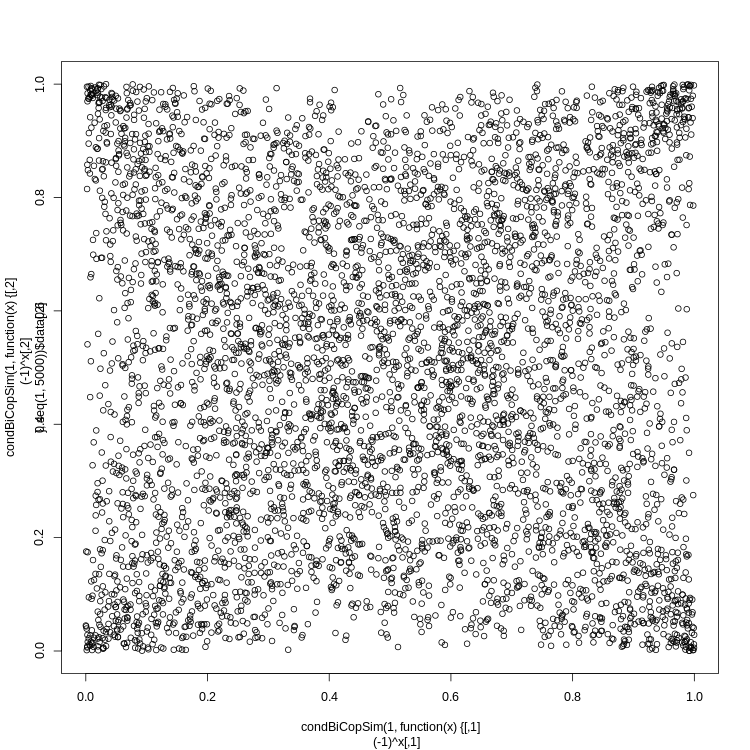

In [2]:
plot(condBiCopSim(1,function(x) {(-1)^x}, seq(1,5000))$data)

## Small Bivariate Experiment

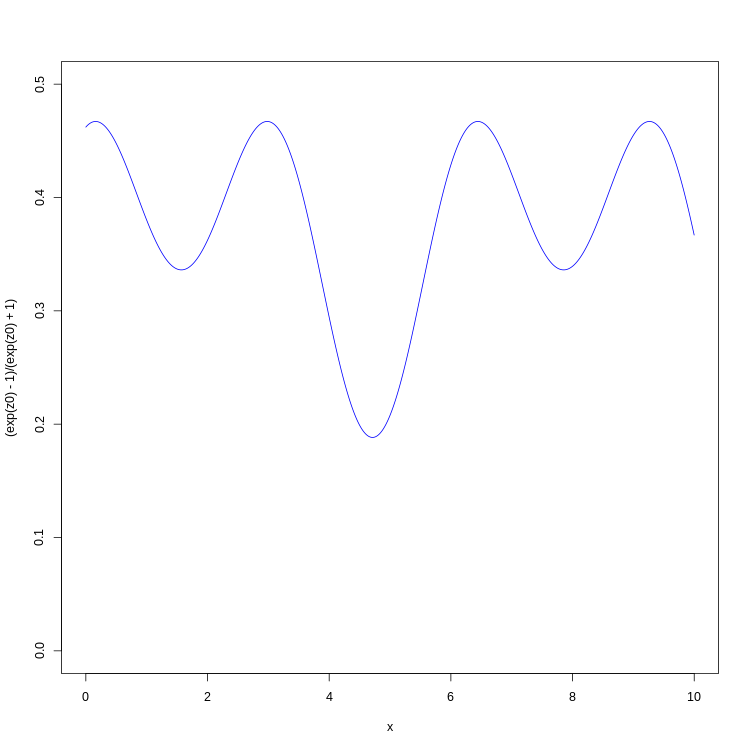

In [3]:
x <- seq(0,10,0.003)
z0 <- sin(x)/(2*pi)+ cos(sin(x))
z1 <- z0 + rnorm(length(x),mean = 0.1,sd = 0.1)

plot(x,(exp(z0)-1)/(exp(z0)+1), type = 'l', col = 'blue', ylim = c(0,0.5)) #Plotting Kendall's Tau when depending on the specified function

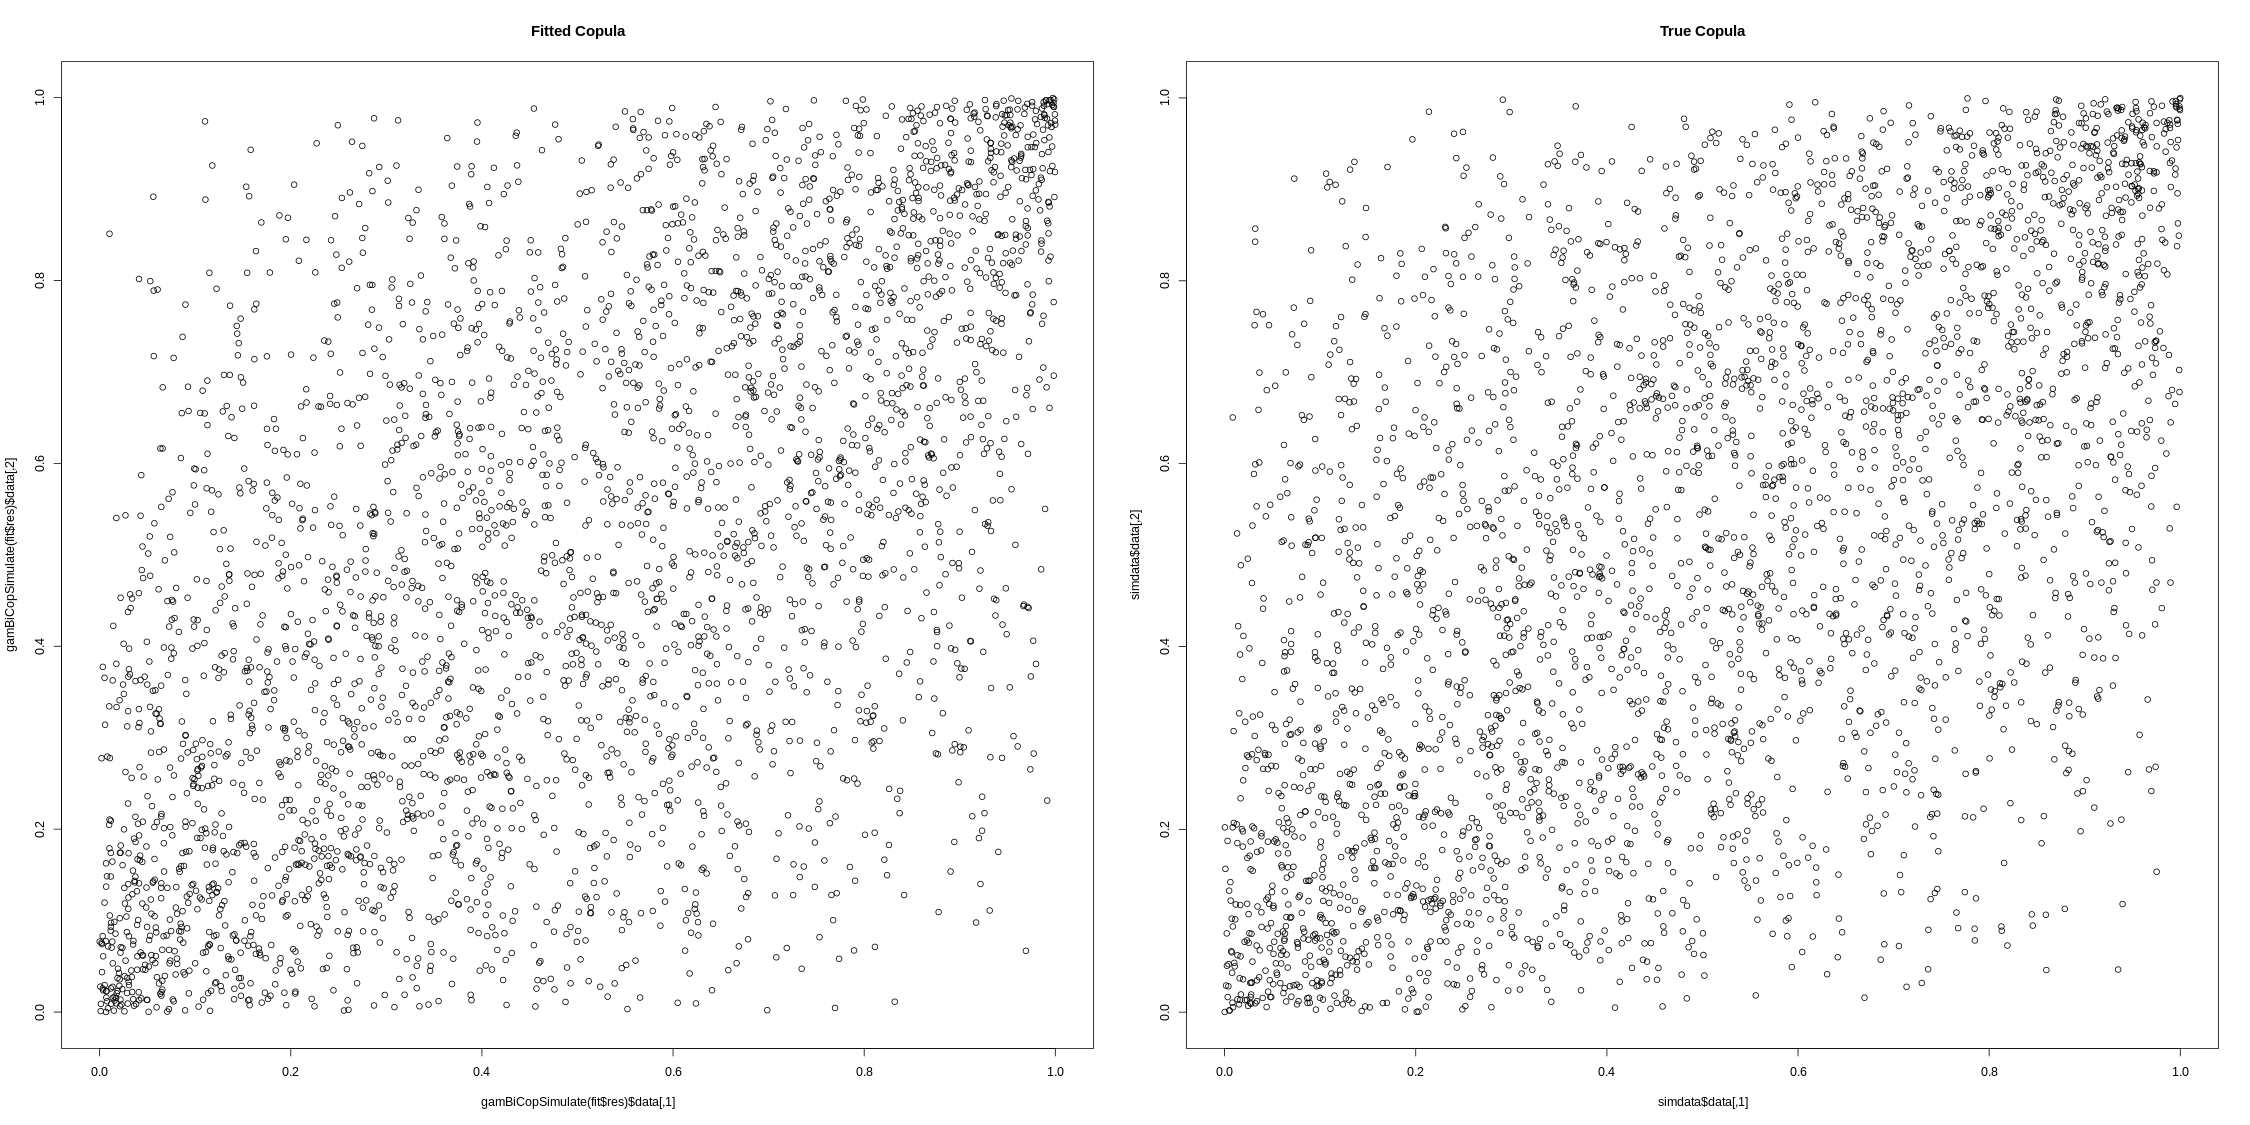

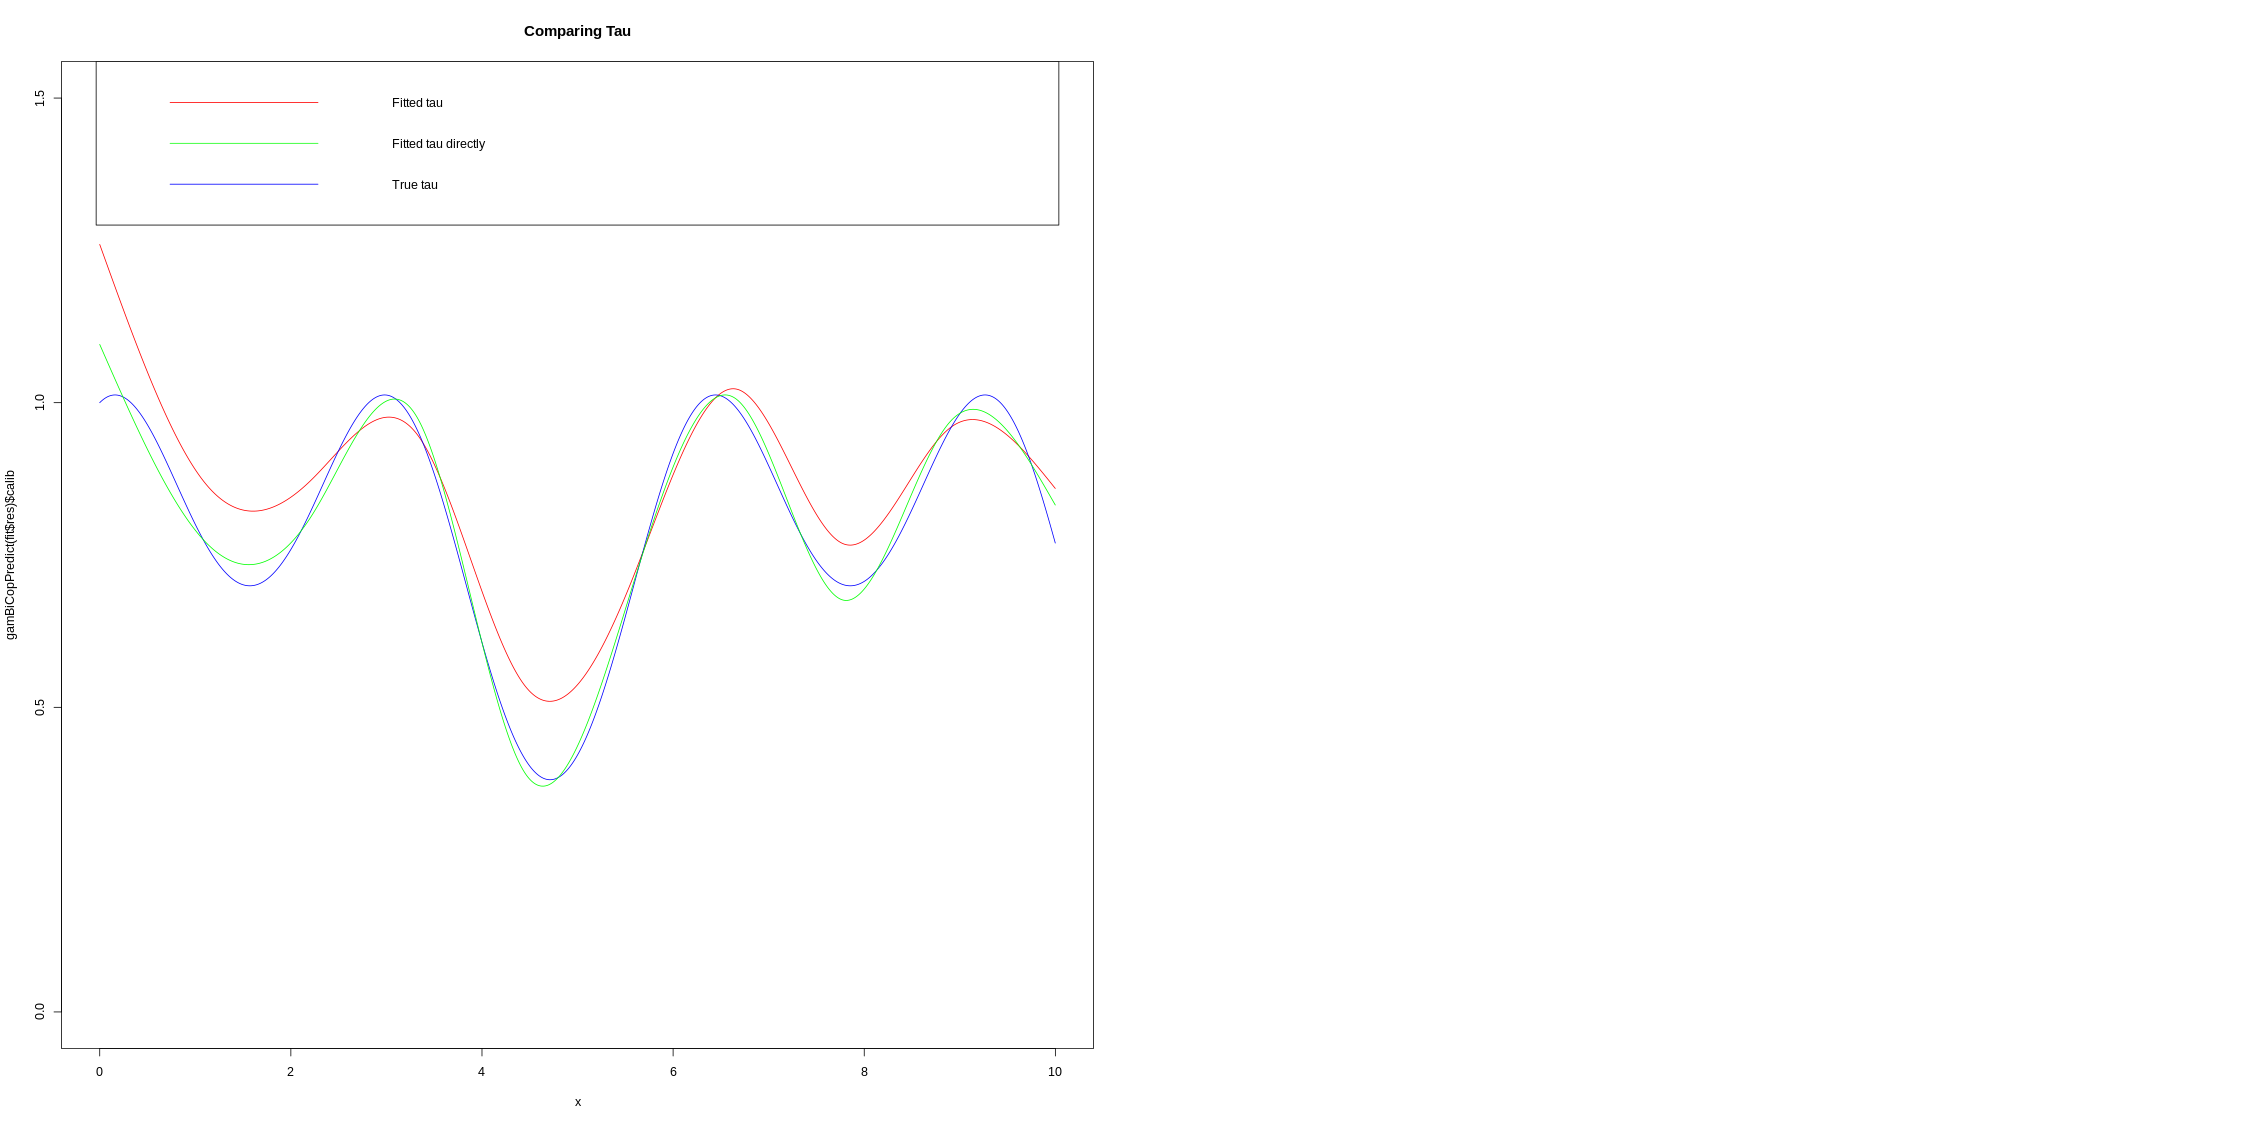

In [4]:
options(repr.plot.width= 30, repr.plot.height= 15)

#Simulating Data with tau depending on covariate x
simdata <- condBiCopSim(1 ,function(t) {sin(t)/(2*pi)+ cos(sin(t))}, x)
data <- data.frame(simdata$data, x)
names(data) <- c('u1','u2','x')

#Fitting a conditional copula with the gam package
fit <- gamBiCopFit(data, ~s(x, k = 10 ,bs = "cr"))
par(mfcol = c(1,2))
plot(gamBiCopSimulate(fit$res)$data, main = 'Fitted Copula')
plot(simdata$data, main = 'True Copula')

#Estimating tau separately via gam package (same formula)
b <- gam(z0 ~ s(x, k = 10, bs = 'cr'))
tau_gam <- predict.gam(b)

#Plotting True tau vs the two fitted ones
plot(x,gamBiCopPredict(fit$res)$calib, type = 'l', col = 'red', ylim = c(0,1.5), main = 'Comparing Tau')
lines(x,z0, type = 'l', col = 'blue')
lines(x,tau_gam, type = 'l', col = 'green')
legend('top', legend = c('Fitted tau','Fitted tau directly','True tau'), lty = c(1,1,1), col = c('red','green','blue'))

In [5]:
#Comparing AIC to traditional copula fit
library('copula')
fit_classic <- fitCopula(normalCopula(dim = 2, dispstr = 'un'), as.matrix(data[,1:2]))

print(paste('AIC of Gaussian Copula: ', AIC(fit_classic)))
print(paste('AIC of Gaussian gamCopula: ', AIC(fit$res)))

pacotest(data[,1:2],data[,3], 'CCC')$pValue

[1] "AIC of Gaussian Copula:  -1280.62395750874"
[1] "AIC of Gaussian gamCopula:  -1329.82669901074"


[1] 0.06769717

## Vine Copulas - Multidimensional Simulation Study

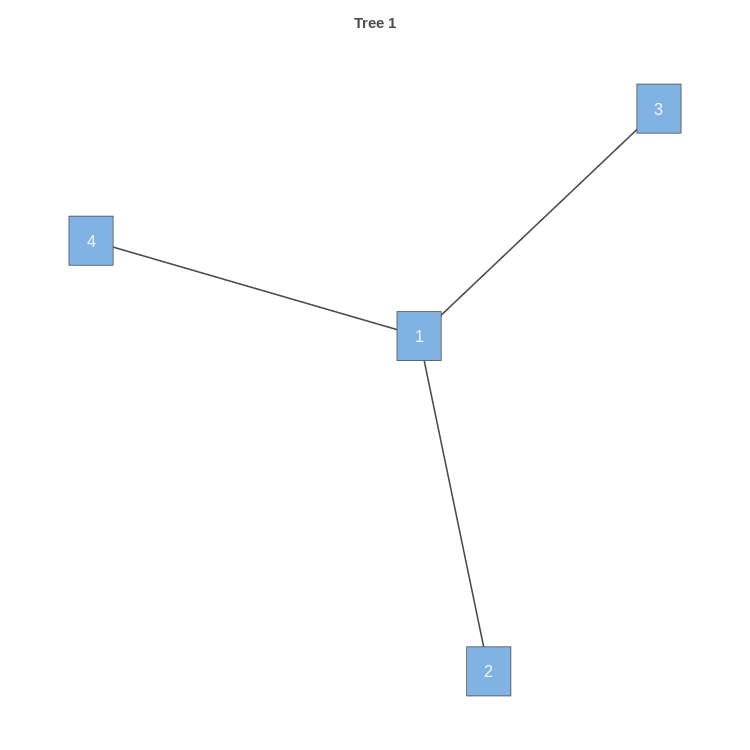

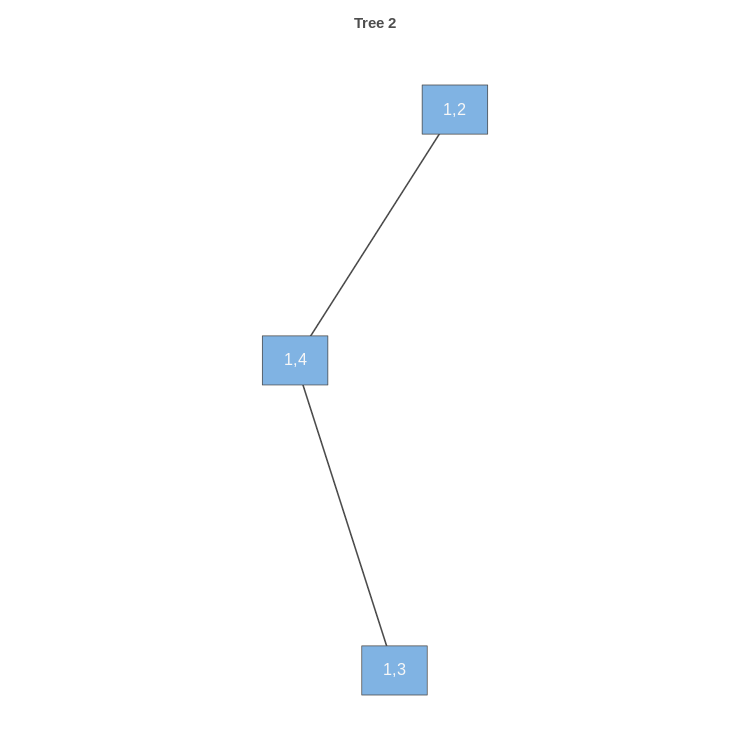

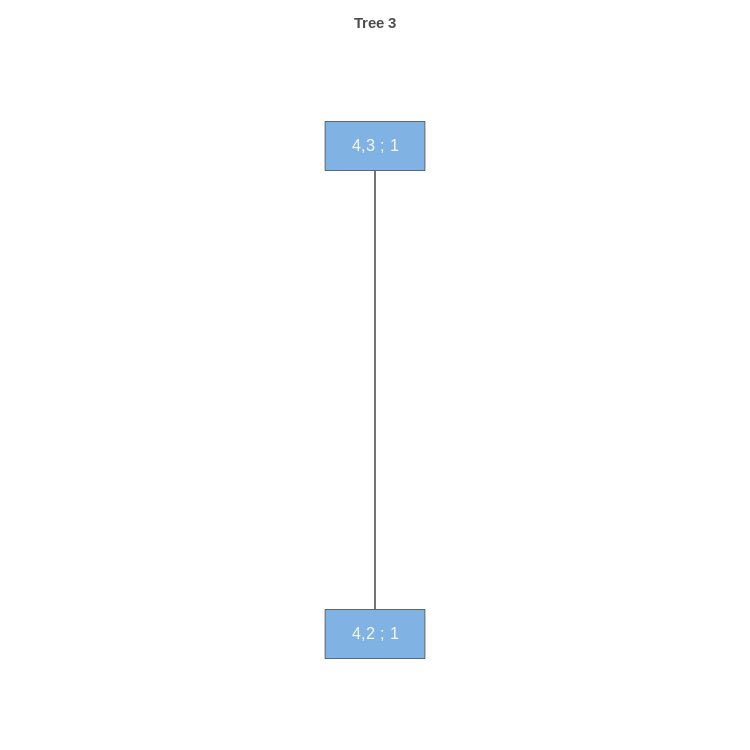

In [6]:
library('VineCopula')

#Defining an R-vine array
#Matrix <- c(3,0,0,0,
#            1,4,0,0,
#            4,1,2,0,
#            2,2,1,1)

#Matrix <- c(3,1,4,2,
#            0,4,1,2,
#            0,0,2,1,
#            0,0,0,1)
#Matrix <- matrix(Matrix,4,4)


#The authors matrix
Matrix <- c(2, 3, 4, 1, 0, 3, 4, 1, 0, 0, 4, 1, 0, 0, 0, 1)
Matrix <- matrix(Matrix, 4, 4)

plot(RVineMatrix(Matrix = Matrix))

GAM-Vine matrix: 
     [,1] [,2] [,3] [,4]
[1,]    2    0    0    0
[2,]    3    3    0    0
[3,]    4    4    4    0
[4,]    1    1    1    1

 Where 
1  <->  X1 
2  <->  X2 
3  <->  X3 
4  <->  X4 

 Tree 1: 
X2,X1: Gaussian 
X3,X1: t 
X4,X1: Clayton type 1 (standard and 90 degrees rotated) 

 Tree 2: 
X2,X4|X1 : Clayton type 2 (standard and 270 degrees rotated) copula with tau(z) = (exp(z)-1)/(exp(z)+1) where 
y ~ s(X1, k = 10, bs = "cr")
X3,X4|X1 : Clayton type 3 (survival and 90 degrees rotated) copula with tau(z) = (exp(z)-1)/(exp(z)+1) where 
y ~ s(X1, k = 10, bs = "cr")

 Tree 3: 
X2,X3|X4,X1 : Gumbel type 3 (survival and 90 degrees rotated) copula with tau(z) = (exp(z)-1)/(exp(z)+1) where 
y ~ s(X1, k = 10, bs = "cr") + s(X4, k = 10, bs = "cr")


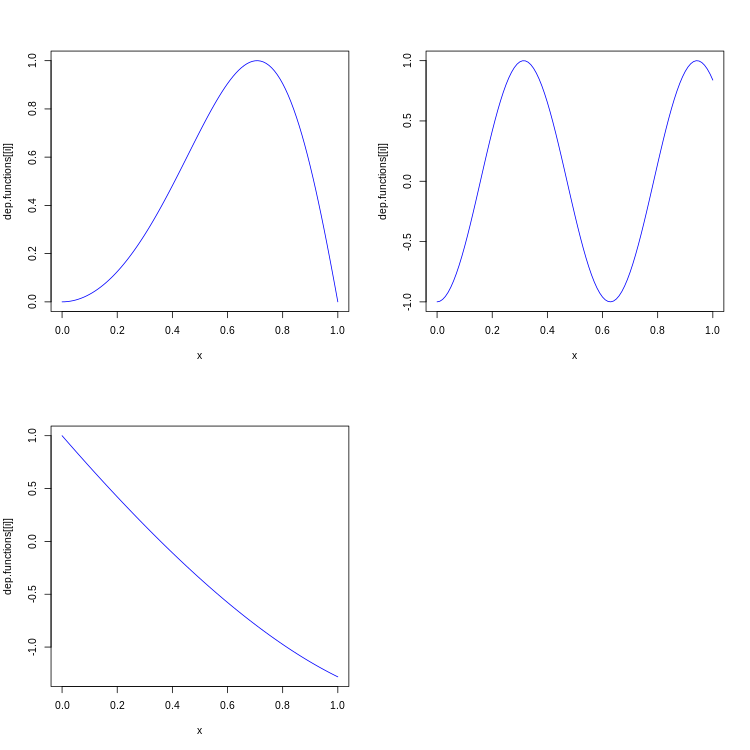

In [17]:
#Defining deterministic dependency functions
dep.functions <- list(function(x) {return ((sin(pi*x^2)))},
                     function(x) {return ((-cos(x/0.1)))},
                     function(x) {return (exp(x)-4*x)})

par(mfrow = c(2,2))
for (i in 1:length(dep.functions)) {
    plot(dep.functions[[i]], xlim = c(0,1), col = 'blue')
}

d <- 4     #d dimensional vine specified above
models <- vector(mode = 'list', length = d*(d-1)/2)
family.selection <- c(1,2,301,302,303,401,402,403) #Gauss, T, Double Claytons , Double Gumbels

#Model specification

#First Tree
models[[1]]$family <- 1 #Gaussian
models[[2]]$family <- 2 #T-Copula
models[[3]]$family <- 301 #Double Clayton type 1

models[[1]]$par <- runif(1,min = -1,max = 1)
models[[2]]$par <- runif(1, min = -1, max = 1)
models[[3]]$par <- runif(1,min = -10, max = 10)

models[[2]]$par2 <- 4

n.cov <- 100
tmp.stops <- seq(0,1,length.out = n.cov)

#Intermediate Tree
for (i in 4:5){
    tmp.fcts <- sample(1:length(dep.functions), 1)
    tmp.x <- tmp.stops
    tmp.y <- mapply(function(x) dep.functions[[tmp.fcts[1]]](x),
                    tmp.x)
    tmp.data <- data.frame(y = tmp.y, 'X1' = tmp.x)
    tmp.formula <- y ~ s(X1, k = 10, bs = 'cr')
    tmp.model <- gam(tmp.formula, data = tmp.data)
    tmp.family <- sample(family.selection,1)

    if (tmp.family ==2){
        tmp.par2 <- sample(2:10,1)
        models[[i]] <- gamBiCop(tmp.family, model = tmp.model, par2 = tmp.par2)
    } else{
        models[[i]] <- gamBiCop(tmp.family, model = tmp.model)
    }
}


#Final Tree
tmp.fcts <- sample(1:length(dep.functions), 2)
tmp.x <- expand.grid(tmp.stops, tmp.stops)
tmp.y <- mapply(function(x,y) dep.functions[[tmp.fcts[1]]](x) + dep.functions[[tmp.fcts[[2]]]](y),
                tmp.x[,1],tmp.x[,2])
tmp.data <- data.frame(y = tmp.y, 'X1' = tmp.x[,1], 'X4' = tmp.x[,2])
tmp.model <- gam(y ~ s(X1, k = 10, bs = 'cr') + s(X4, k = 10, bs = 'cr'), data = tmp.data)
tmp.family <- sample(family.selection,1)
if (tmp.family ==2){
    tmp.par2 <- sample(2:10,1)
    models[[6]] <- gamBiCop(tmp.family, model = tmp.model, par2 = tmp.par2)
} else{
    models[[6]] <- gamBiCop(tmp.family, model = tmp.model)
}

gvine <- gamVine(Matrix, models, names = c('X1','X2','X3','X4'))
print(gvine)

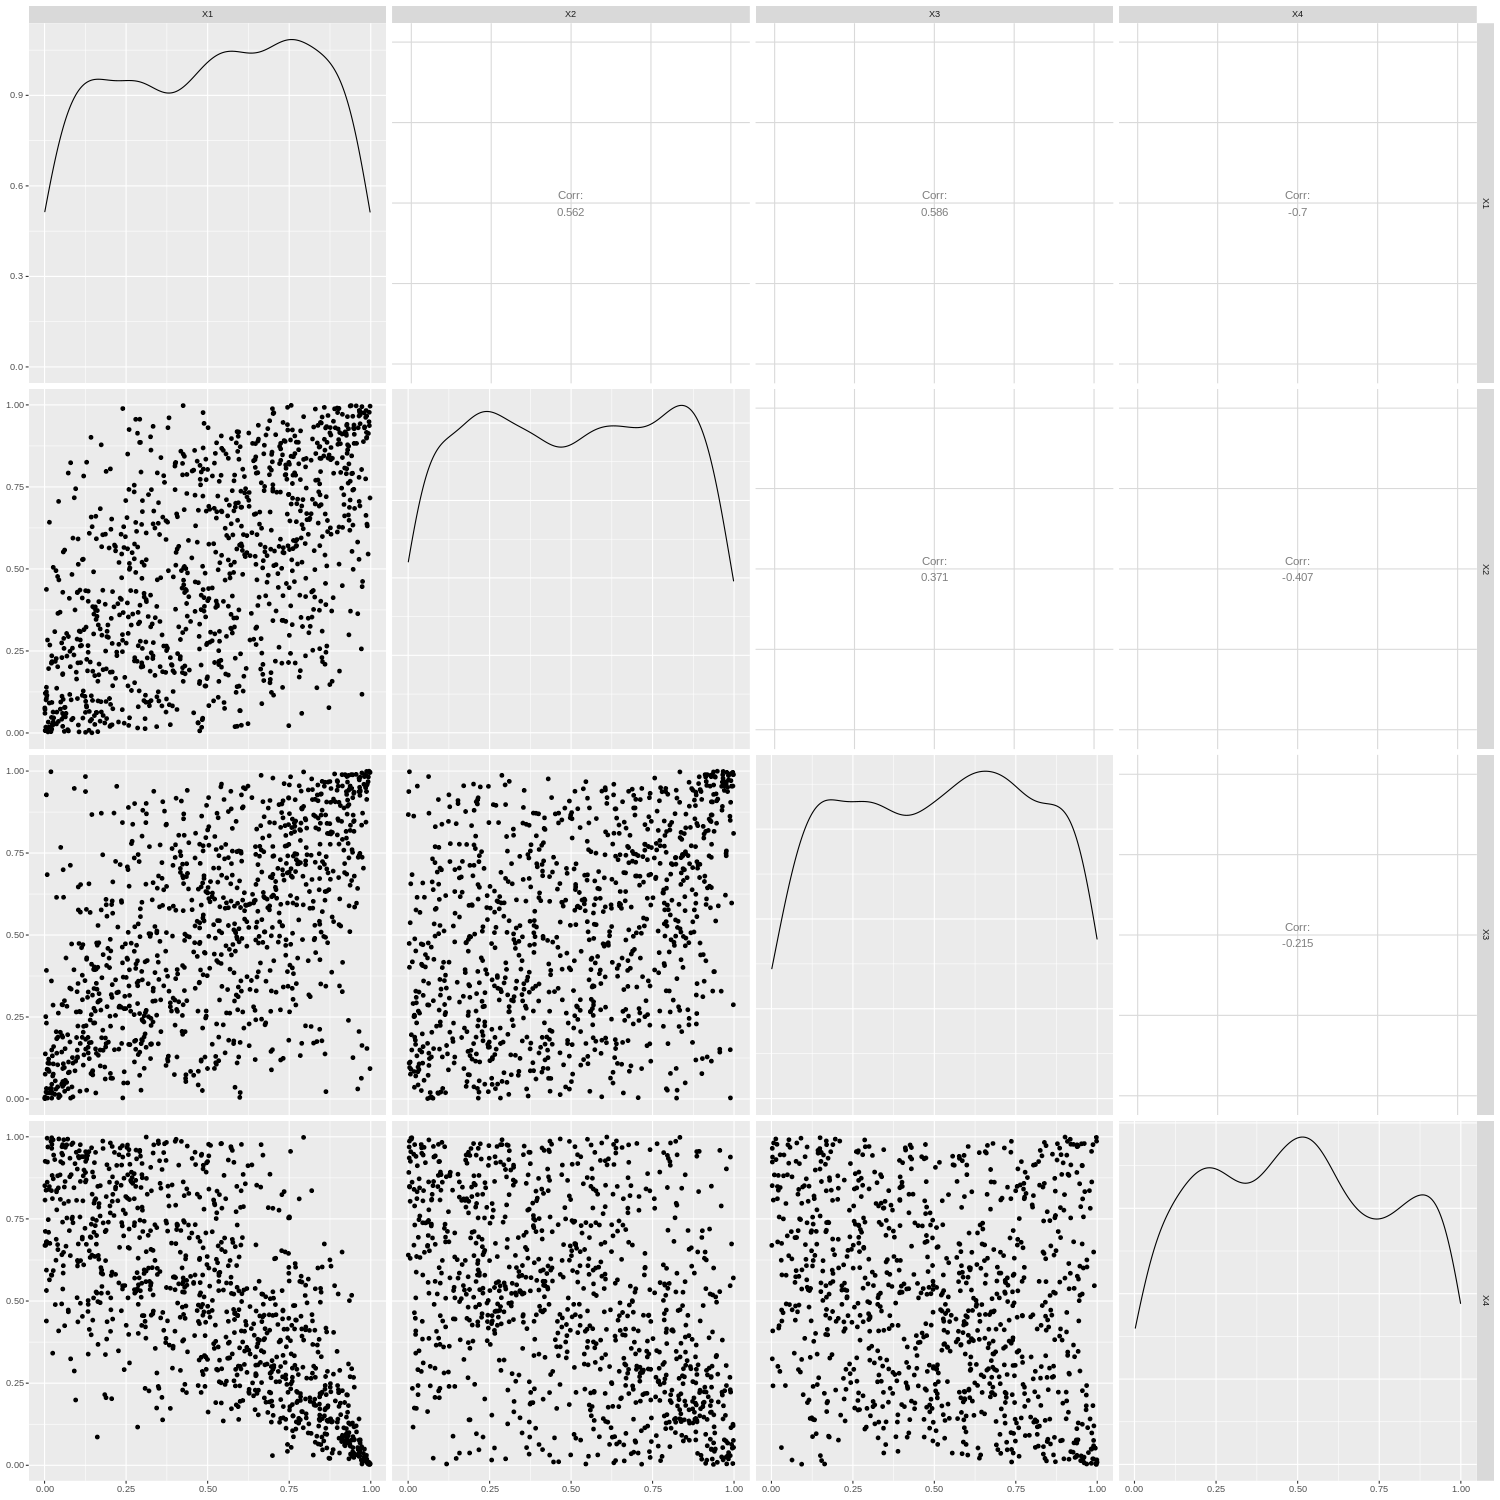

In [25]:
library('GGally')
options(repr.plot.width = 20, repr.plot.height = 20, repr.plot.res = 75)

sim.data <- gamVineSimulate(1000,gvine)
ggpairs(data.frame(sim.data))

In [26]:
fit1 <- gamVineSeqFit(sim.data, gvine)
fit2 <- gamVineCopSelect(sim.data, Matrix, verbose = TRUE)

4,1

3,1

3,4|1

2,1

2,4|1

2,3|4,1



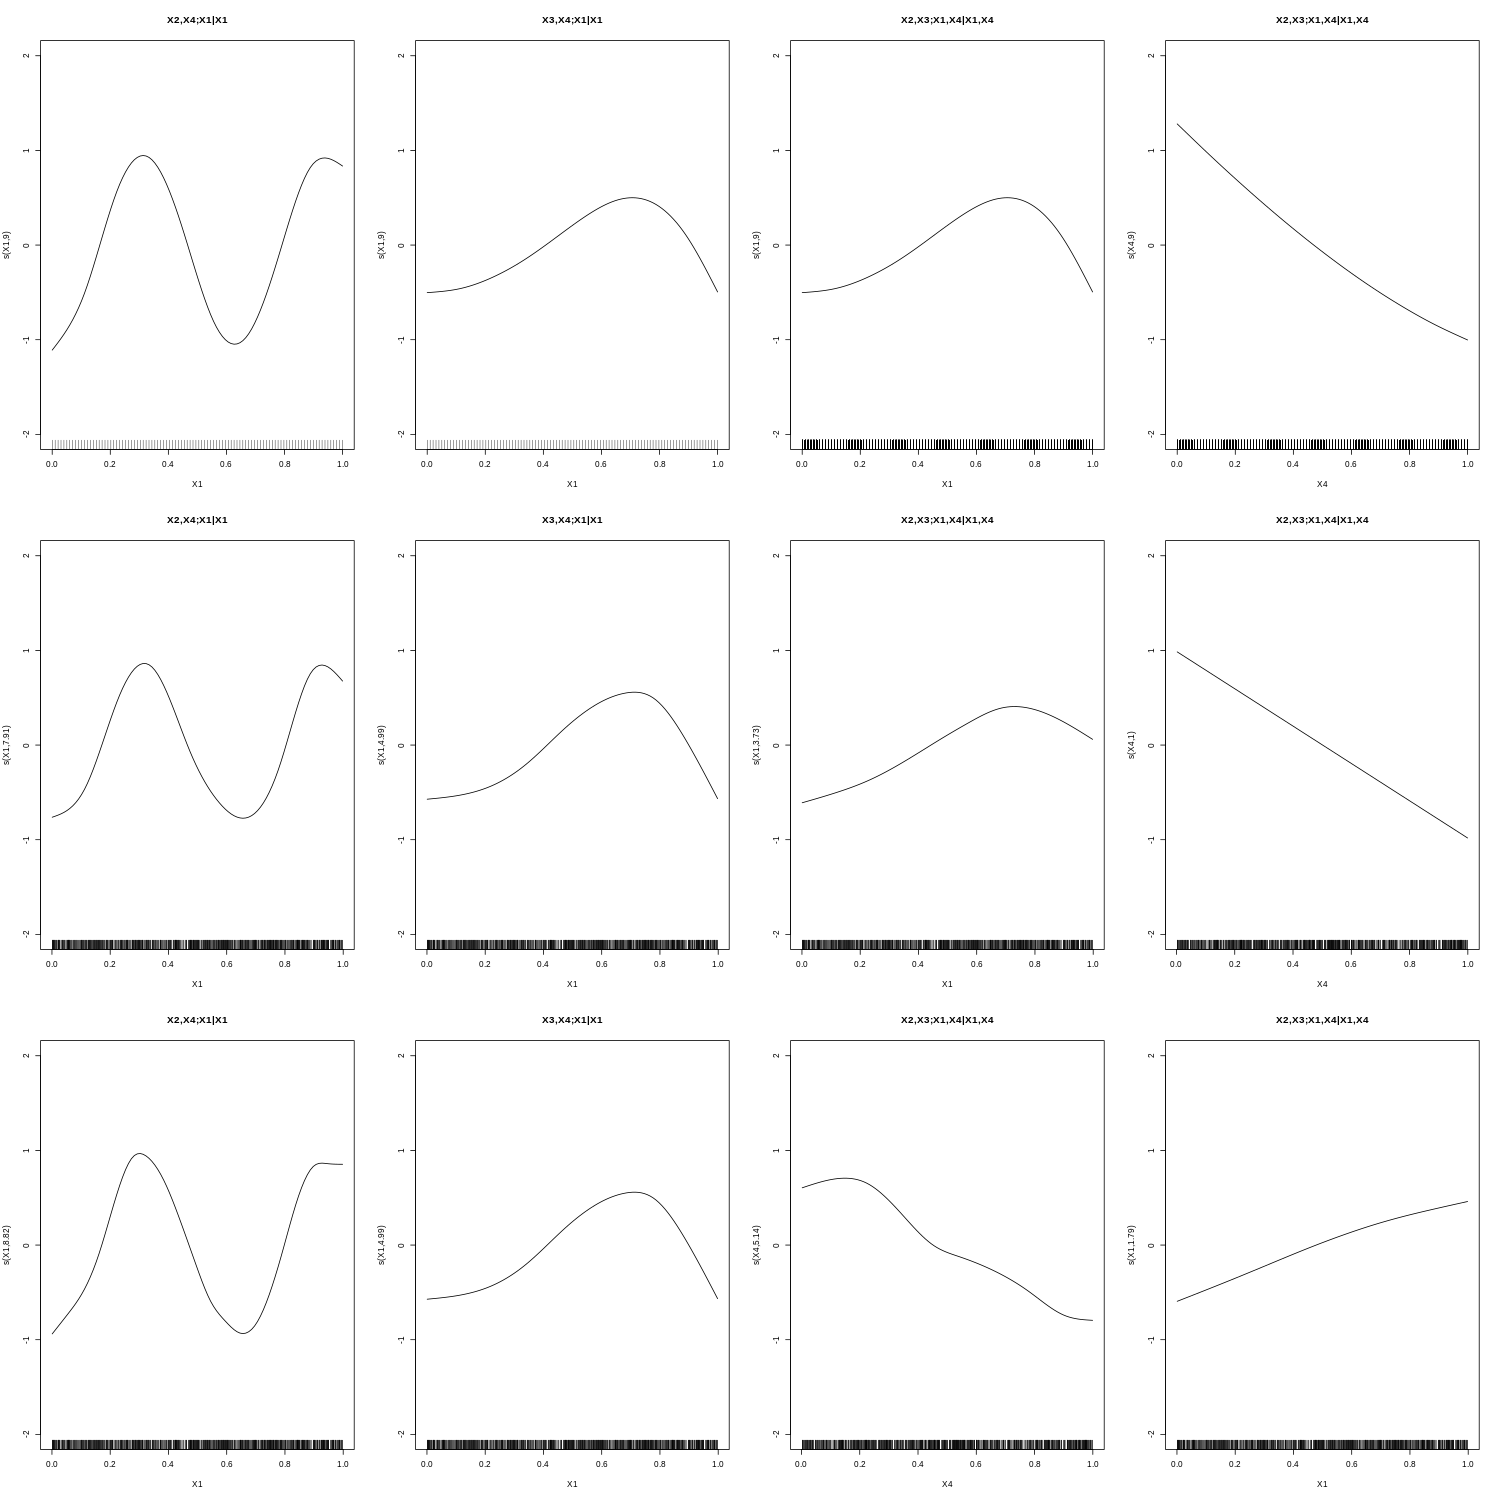

In [27]:
par(mfrow = c(3,4))

plot(gvine,ylim = c(-2,2))
plot(fit1, ylim = c(-2,2))
plot(fit2, ylim = c(-2,2))

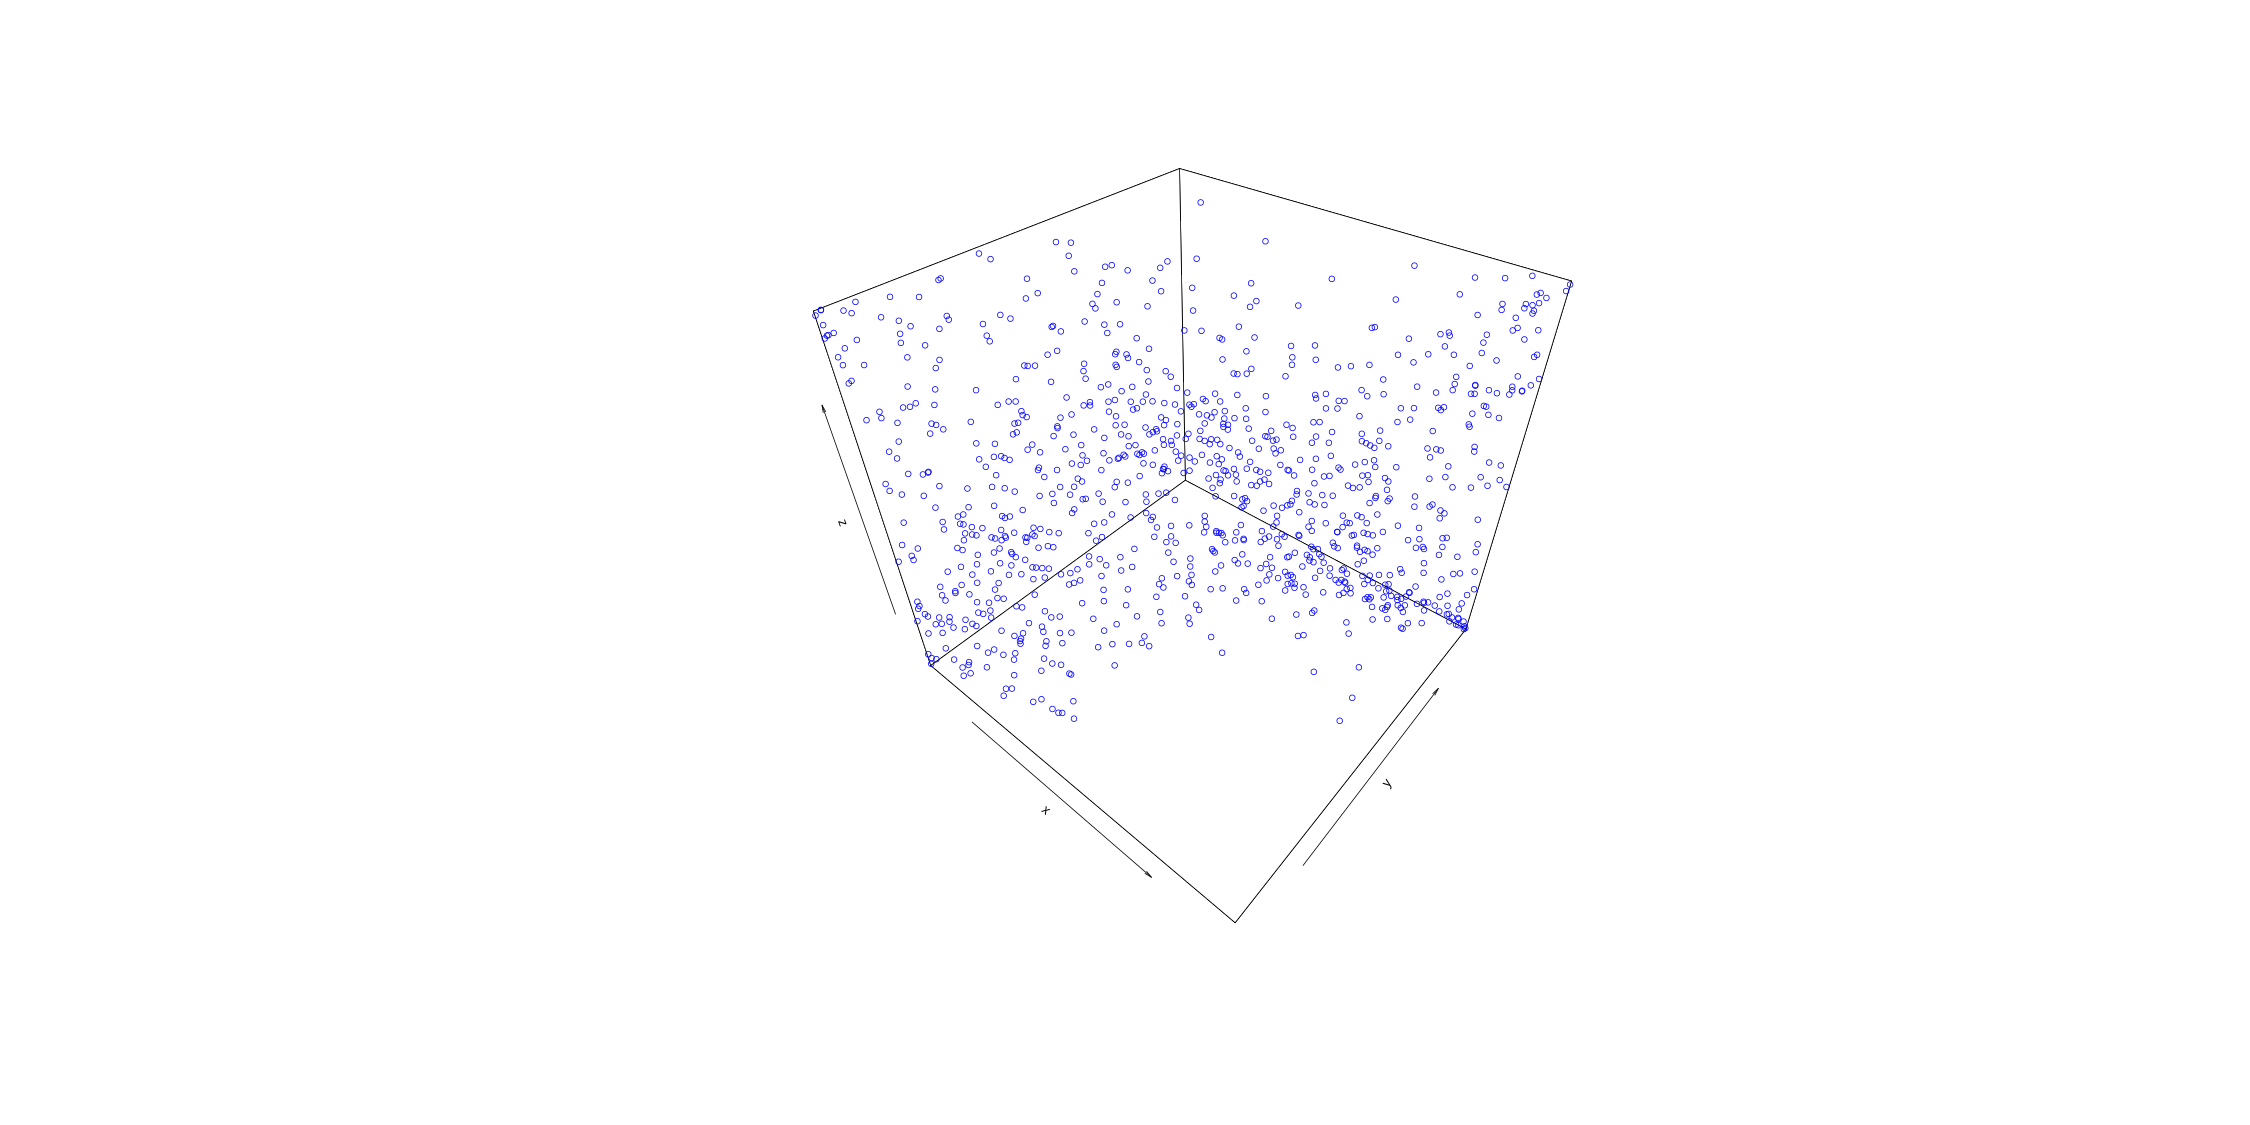

In [20]:
library('plot3D')
scatter3D(sim.data[,1],sim.data[,2],sim.data[,3],col = 'blue')

# Back to three dimensions

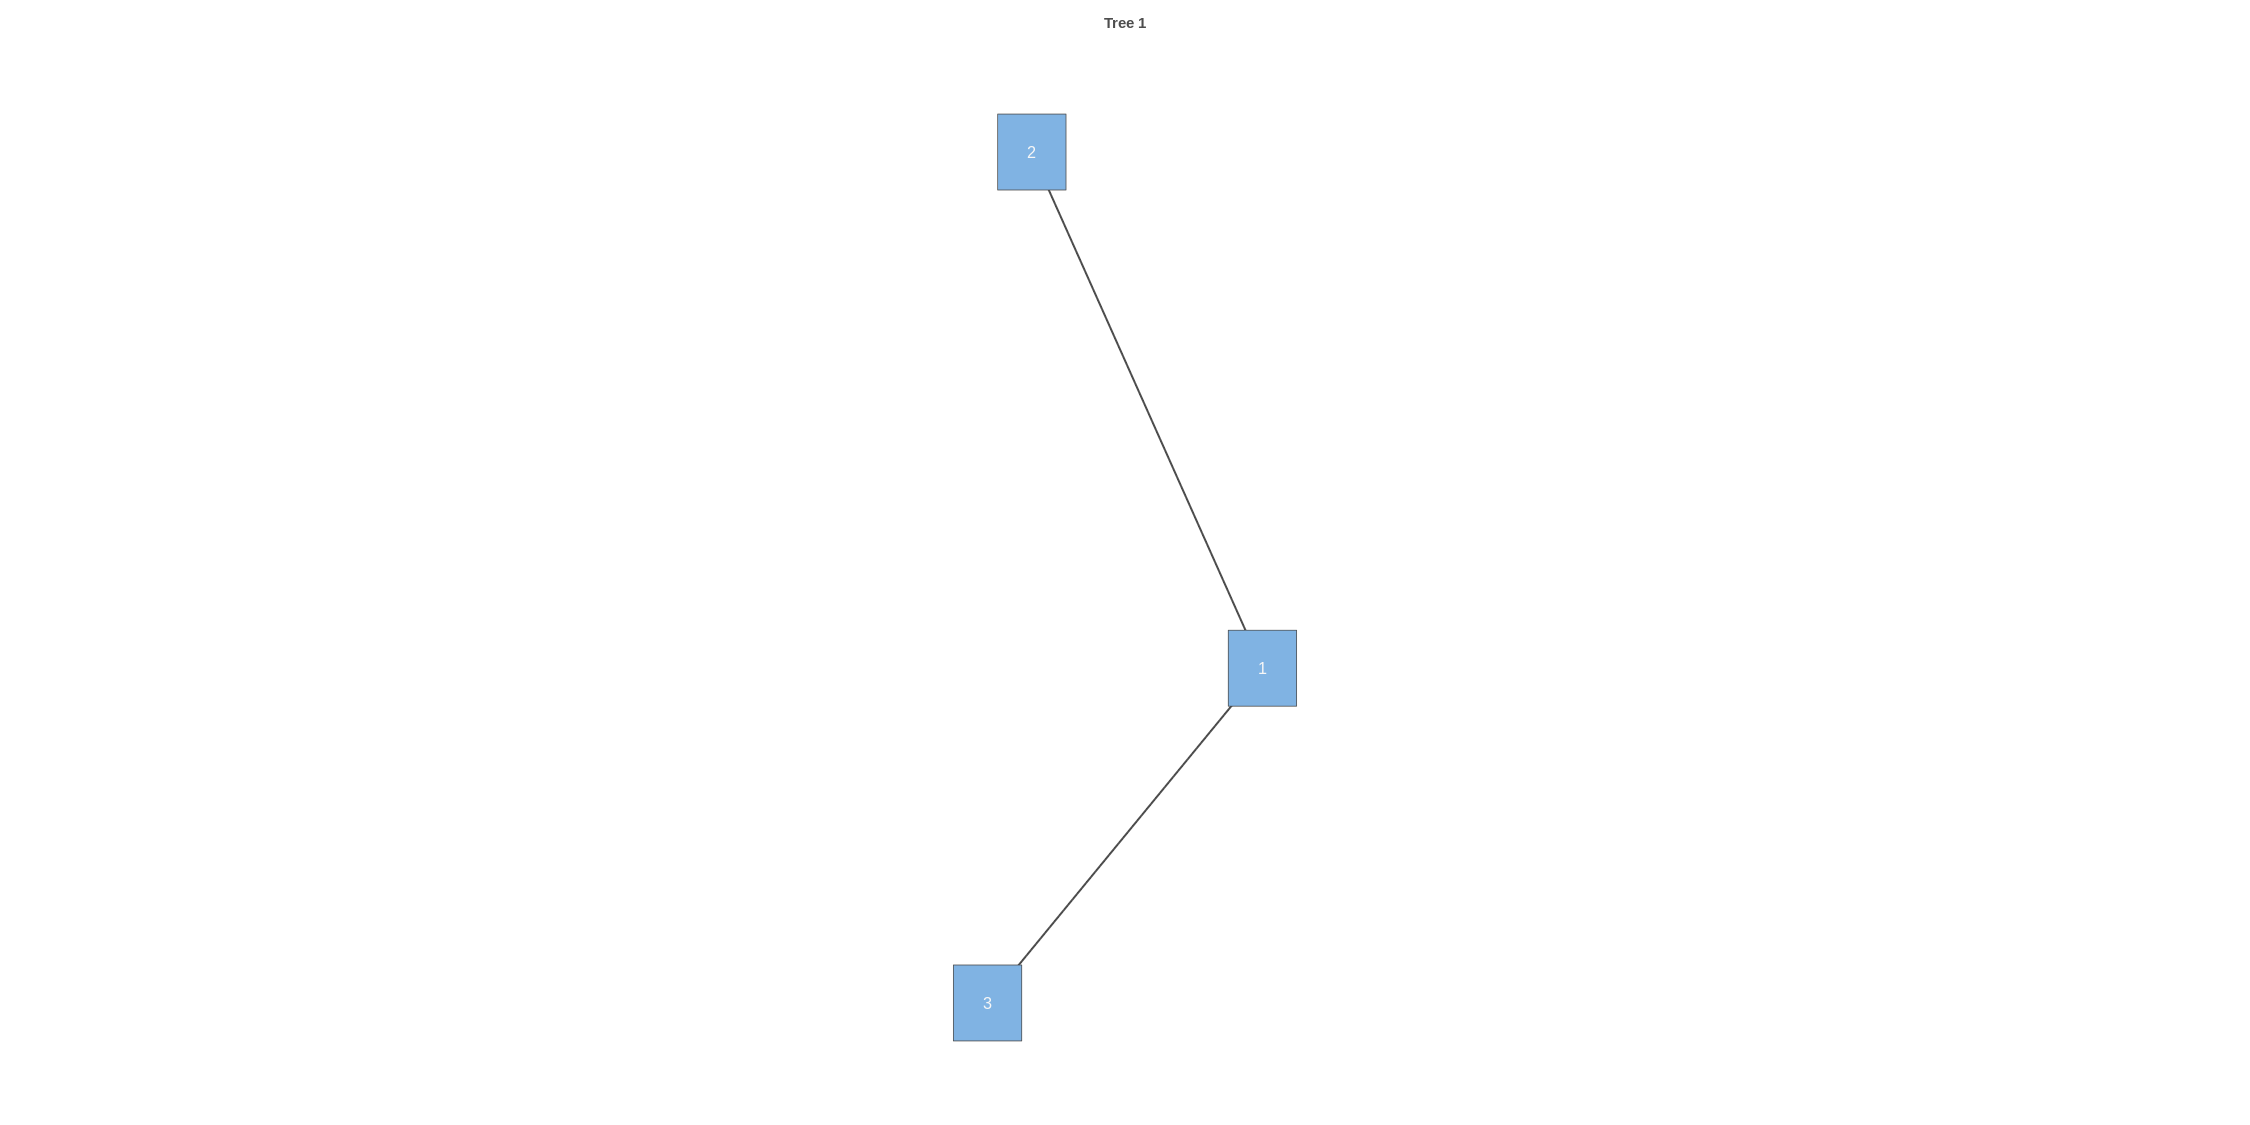

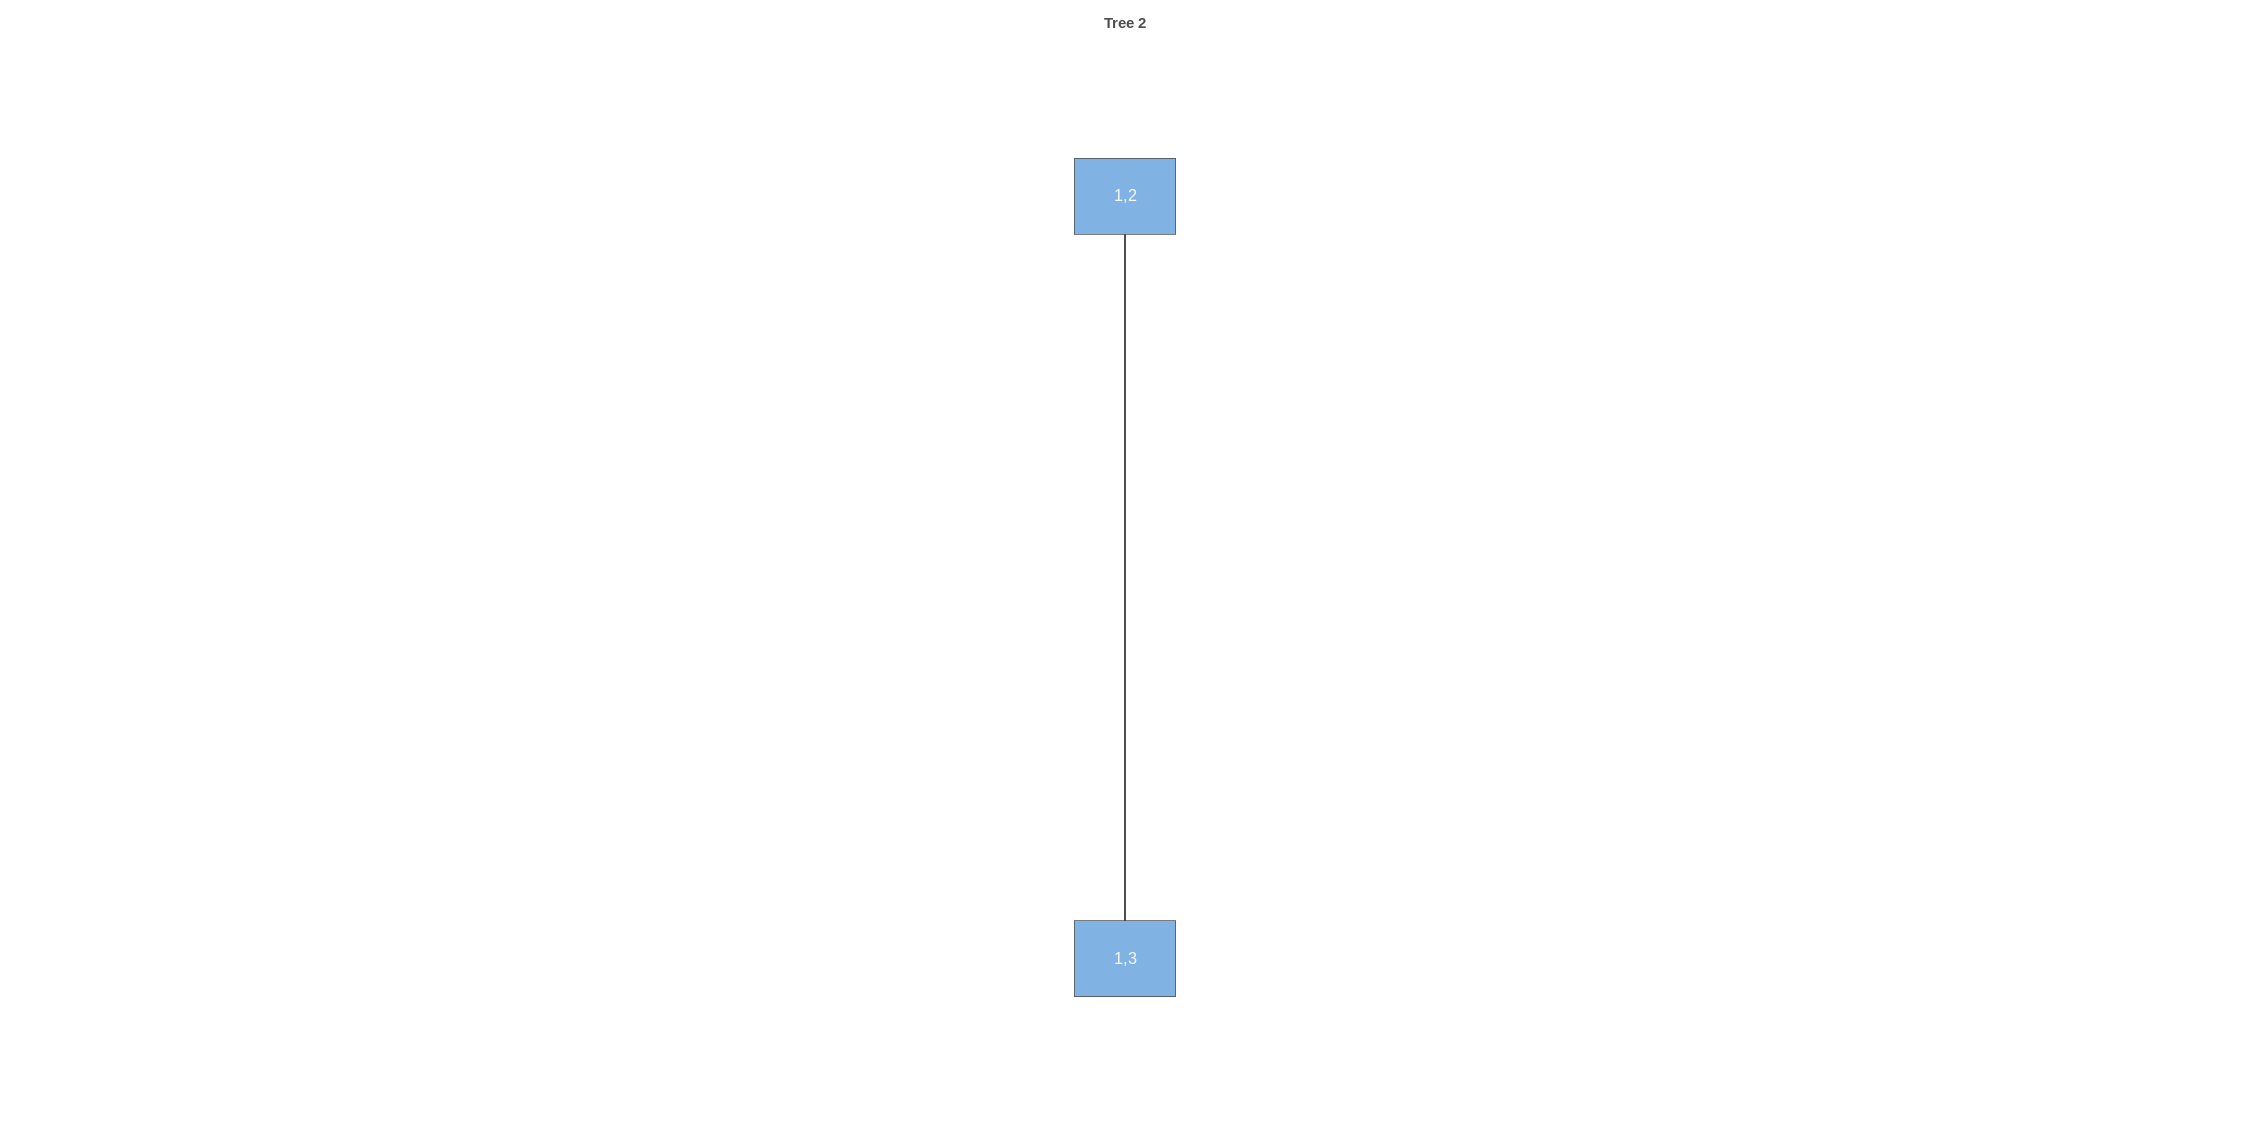

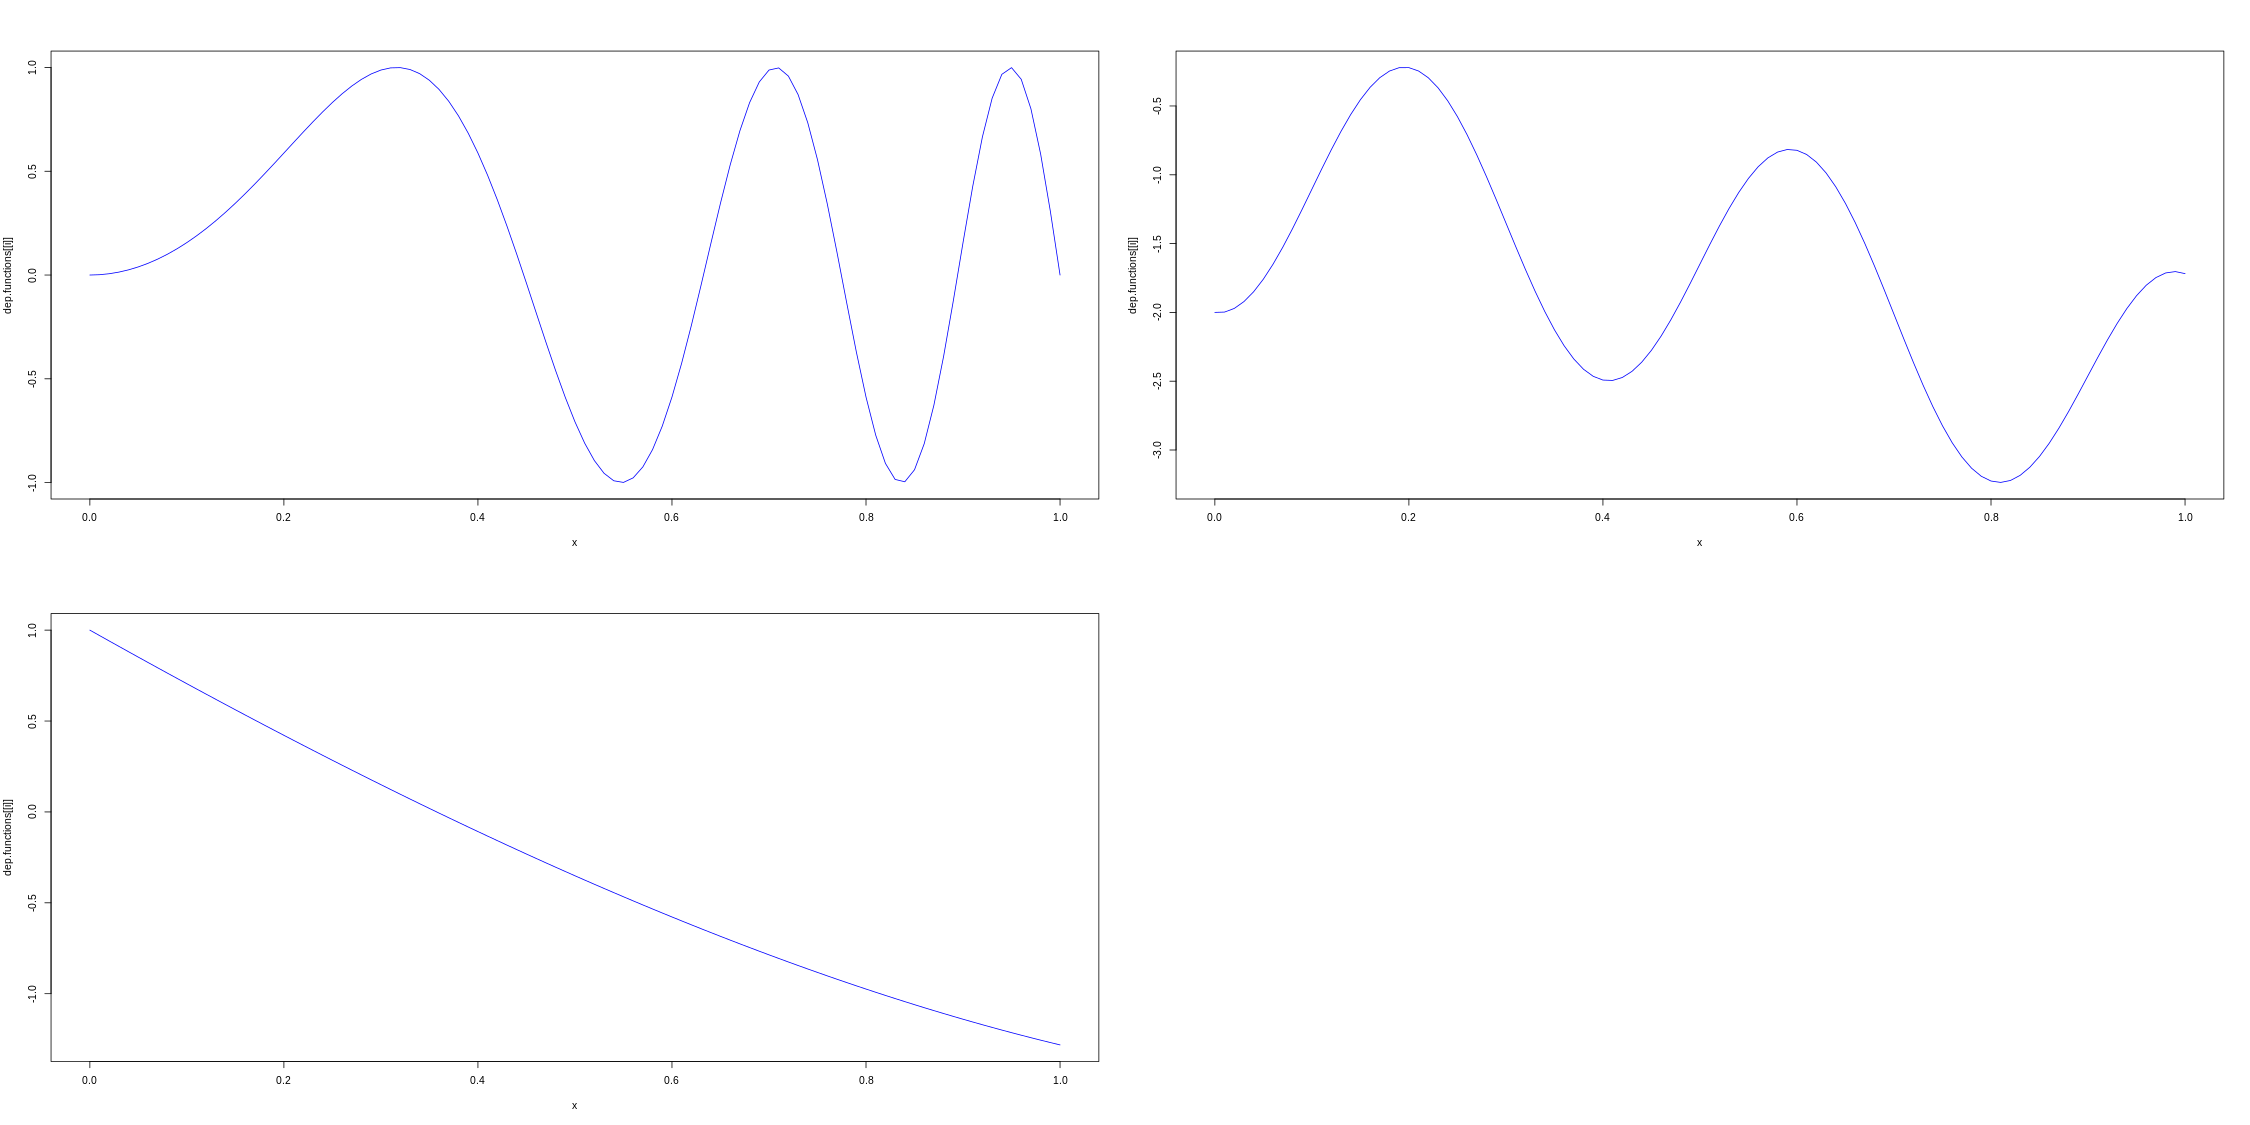

In [7]:
library('VineCopula')



Matrix <- c(2,3,1,
            0,3,1,
            0,0,1)

Matrix <- matrix(Matrix,3,3)
plot(RVineMatrix(Matrix = Matrix))

dep.functions <- list(function(x) {return ((sin(5*pi*x^2)))},
                     function(x) {return ((-cos(5*pi*x)- exp(x)))},
                     function(x) {return (exp(x)-4*x)})

par(mfrow = c(2,2))
for (i in 1:length(dep.functions)) {
    plot(dep.functions[[i]], xlim = c(0,1), col = 'blue')
}



GAM-Vine matrix: 
     [,1] [,2] [,3]
[1,]    2    0    0
[2,]    3    3    0
[3,]    1    1    1

 Where 
1  <->  X1 
2  <->  X2 
3  <->  X3 

 Tree 1: 
X2,X1: Gaussian with par=-0.78 (tau=-0.57) 
X3,X1: t with par=-0.57 and par2=3 (tau=-0.38) 

 Tree 2: 
X2,X3|X1 : Clayton type 3 (survival and 90 degrees rotated) copula with tau(z) = (exp(z)-1)/(exp(z)+1) where 
Formula: 
 y ~ s(X1, k = 15, bs = "cr") 
  
 Parametric coefficients: 
             Estimate Std. Error t value Pr(>|t|)     
 (Intercept)  3.00000    0.02006   149.5   <2e-16 *** 
 --- 
 Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1 
  
 Approximate significance of smooth terms: 
         edf Ref.df     F p-value     
 s(X1) 12.49   13.6 175.7  <2e-16 *** 
 --- 
 Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1 
  
 R-sq.(adj) =   0.96   Deviance explained = 96.5% 
 GCV = 0.046534  Scale est. = 0.040258  n = 100 


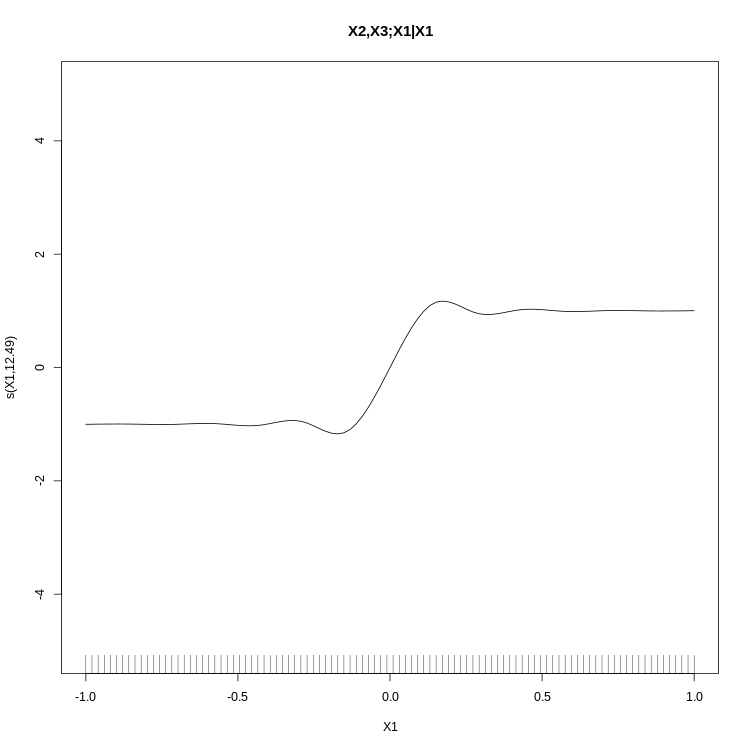

In [46]:
d <- 3    #d dimensional vine specified above
models <- vector(mode = 'list', length = d*(d-1)/2)
family.selection <- c(1,2,301,302,303,401,402,403) #Gauss, T, Double Claytons , Double Gumbels
eta0 <- 3

randomizerfct <- function(x) {
    if(x< 0) return (-1)
    else return (1)
}
oscfct <- function(x) {sin(x)}
linfct <- function(x) {-5*x}


data <- data.frame(u1 = runif(1e2), u2 = runif(1e2), matrix(runif(1e2 * d), 1e2, d))

#Model specification

#First Tree
models[[1]]$family <- 1 #Gaussian
models[[2]]$family <- 2 #T-Copula

models[[1]]$par <- runif(1,min = -1,max = 1)
models[[2]]$par <- runif(1, min = -1, max = 1)

models[[2]]$par2 <- 3

n.cov <- 100 #n covariates


#Conditional Copula on Second Tree
#tmp.fcts <- sample(1:length(dep.functions), 1)
tmp.x <- seq(-1,1,length.out = n.cov)
#tmp.y <- mapply(function(x) dep.functions[[tmp.fcts[1]]](x),
#                tmp.x)
tmp.y <- mapply(function(x) eta0 + randomizerfct(x), tmp.x)
tmp.data <- data.frame(y = tmp.y, 'X1' = tmp.x)
tmp.formula <- y ~ s(X1, k = 15, bs = 'cr')
tmp.model <- gam(tmp.formula, data = tmp.data)
tmp.family <- sample(family.selection,1)
#tmp.family <- 2

if (tmp.family ==2){
    tmp.par2 <- sample(3:10,1)
    models[[3]] <- gamBiCop(tmp.family, model = tmp.model, par2 = tmp.par2)
} else{
    models[[3]] <- gamBiCop(tmp.family, model = tmp.model)
}
                
gvine <- gamVine(Matrix, models, names = c('X1','X2','X3'))
summary(gvine)
plot(gvine,ylim = c(-5, 5))

## Simulate Data from this 3 Dimensional Copula

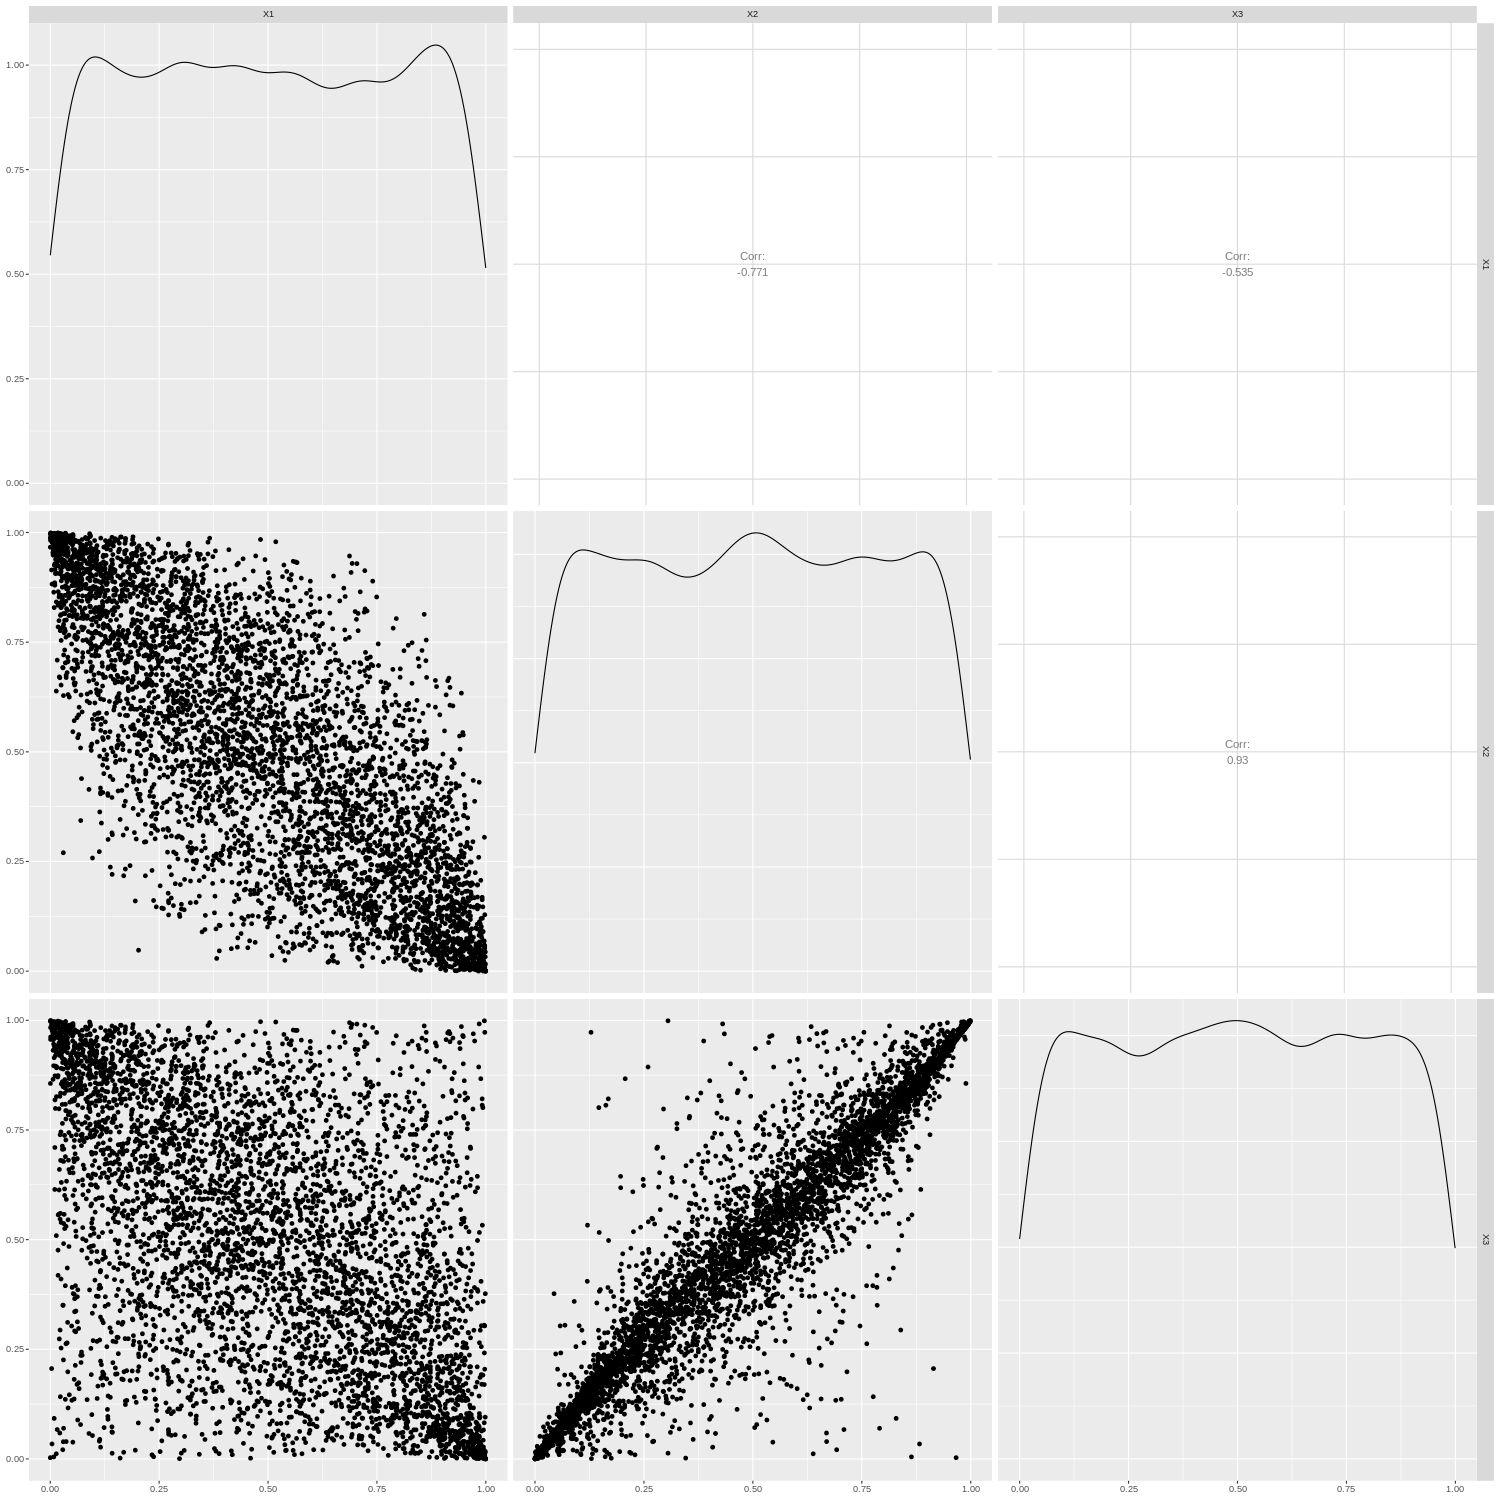

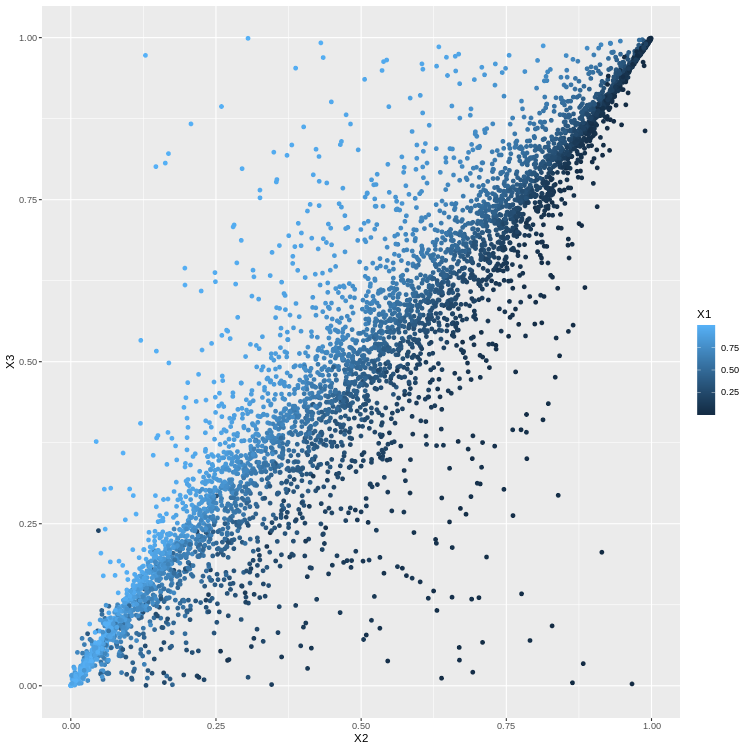

In [47]:
library('GGally')
options(repr.plot.width = 20, repr.plot.height = 20, repr.plot.res = 75)
sim.data <- gamVineSimulate(5000,gvine)
ggpairs(data.frame(sim.data))
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 75)
ggplot(data.frame(sim.data), aes(X2,X3, col = X1)) + geom_point()

## Plotting the Margin 1,3|2

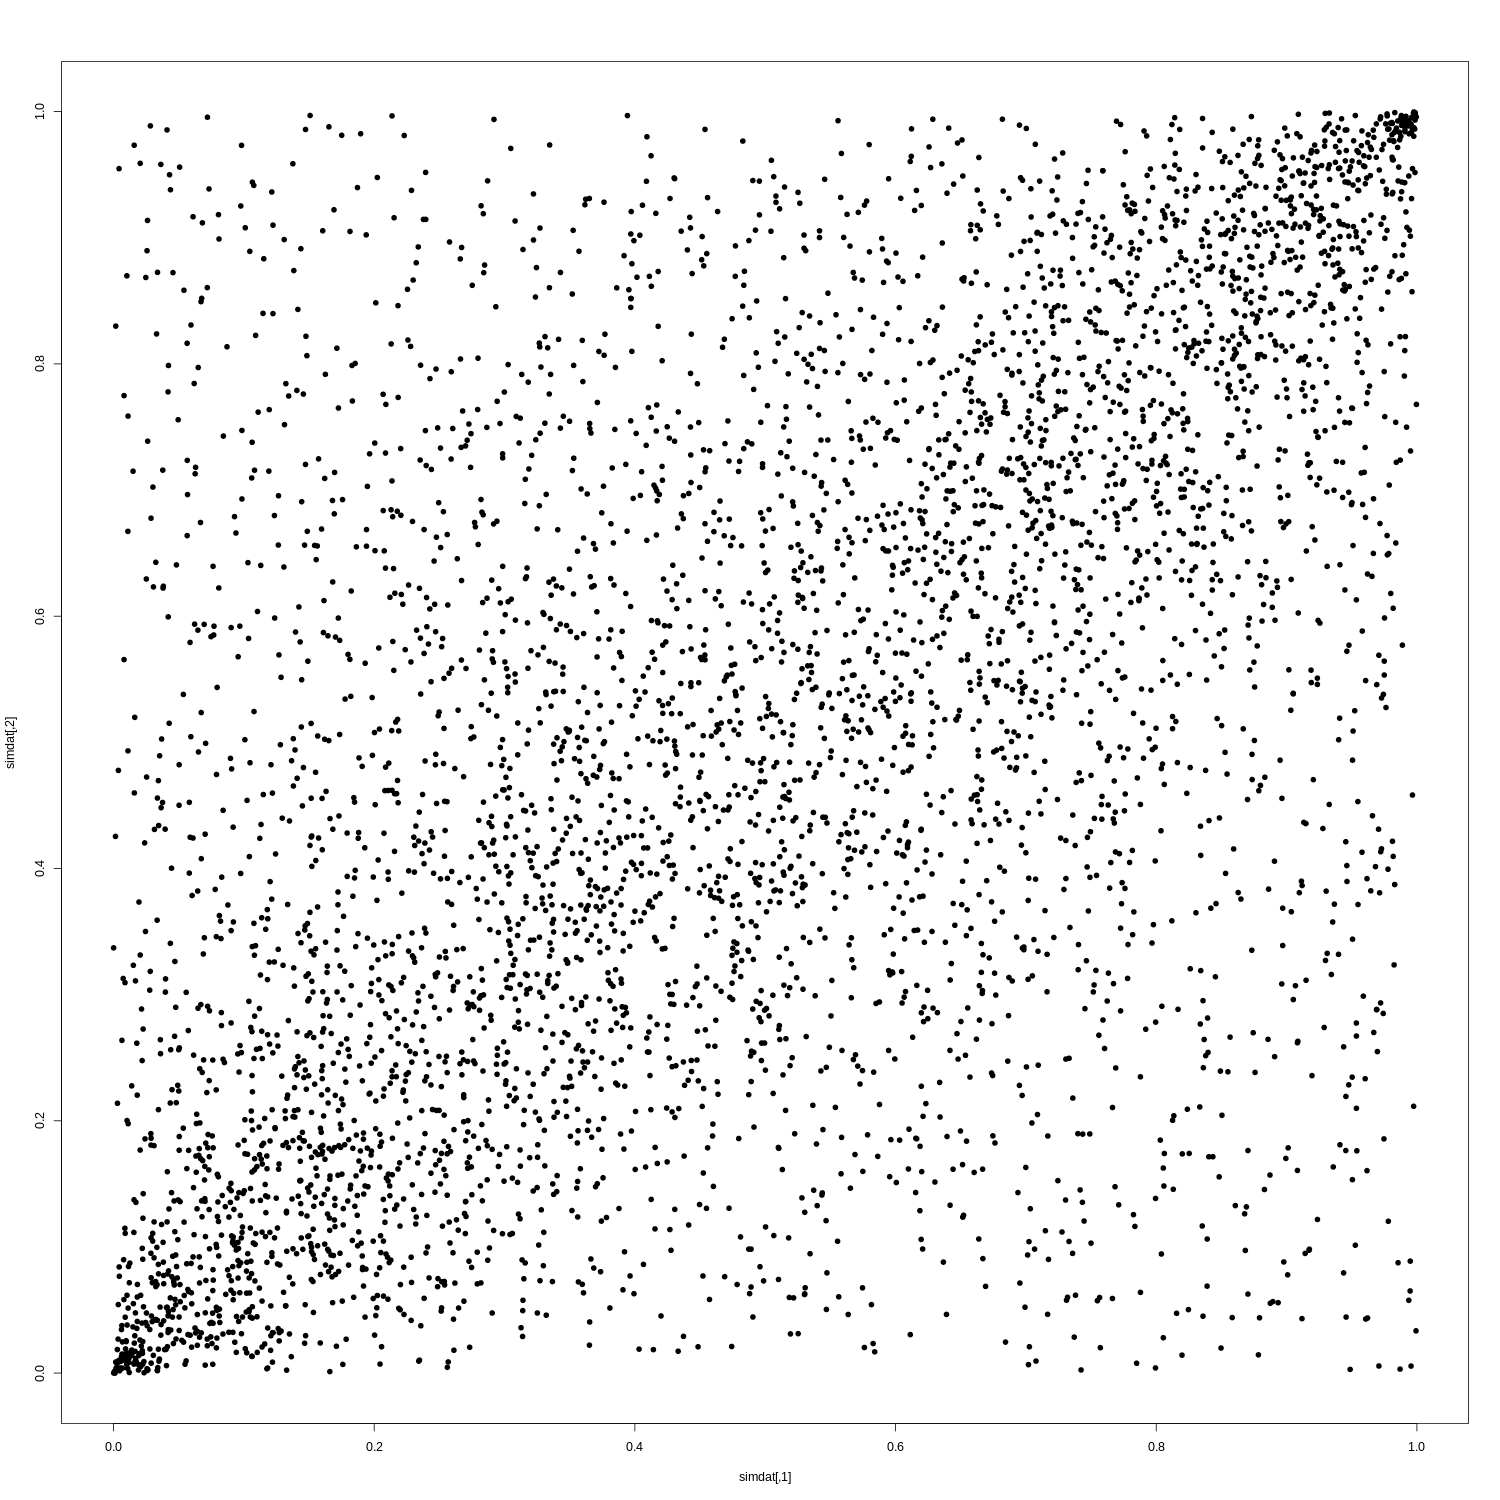

In [24]:
simdat <- gamBiCopSimulate(models[[3]], tmp.data, 5000)$data
plot(simdat,cex = 1.3, pch = 20)

## Fitting Vines to this model

In [25]:
#fit <- gamVineCopSelect(sim.data, Matrix, verbose = TRUE)  #Only the matrix is specified here
fit1 <- gamVineSeqFit(sim.data, gvine, verbose = TRUE)  #the GAMS for individual edges are specified here already

3,1

2,1

2,3|1



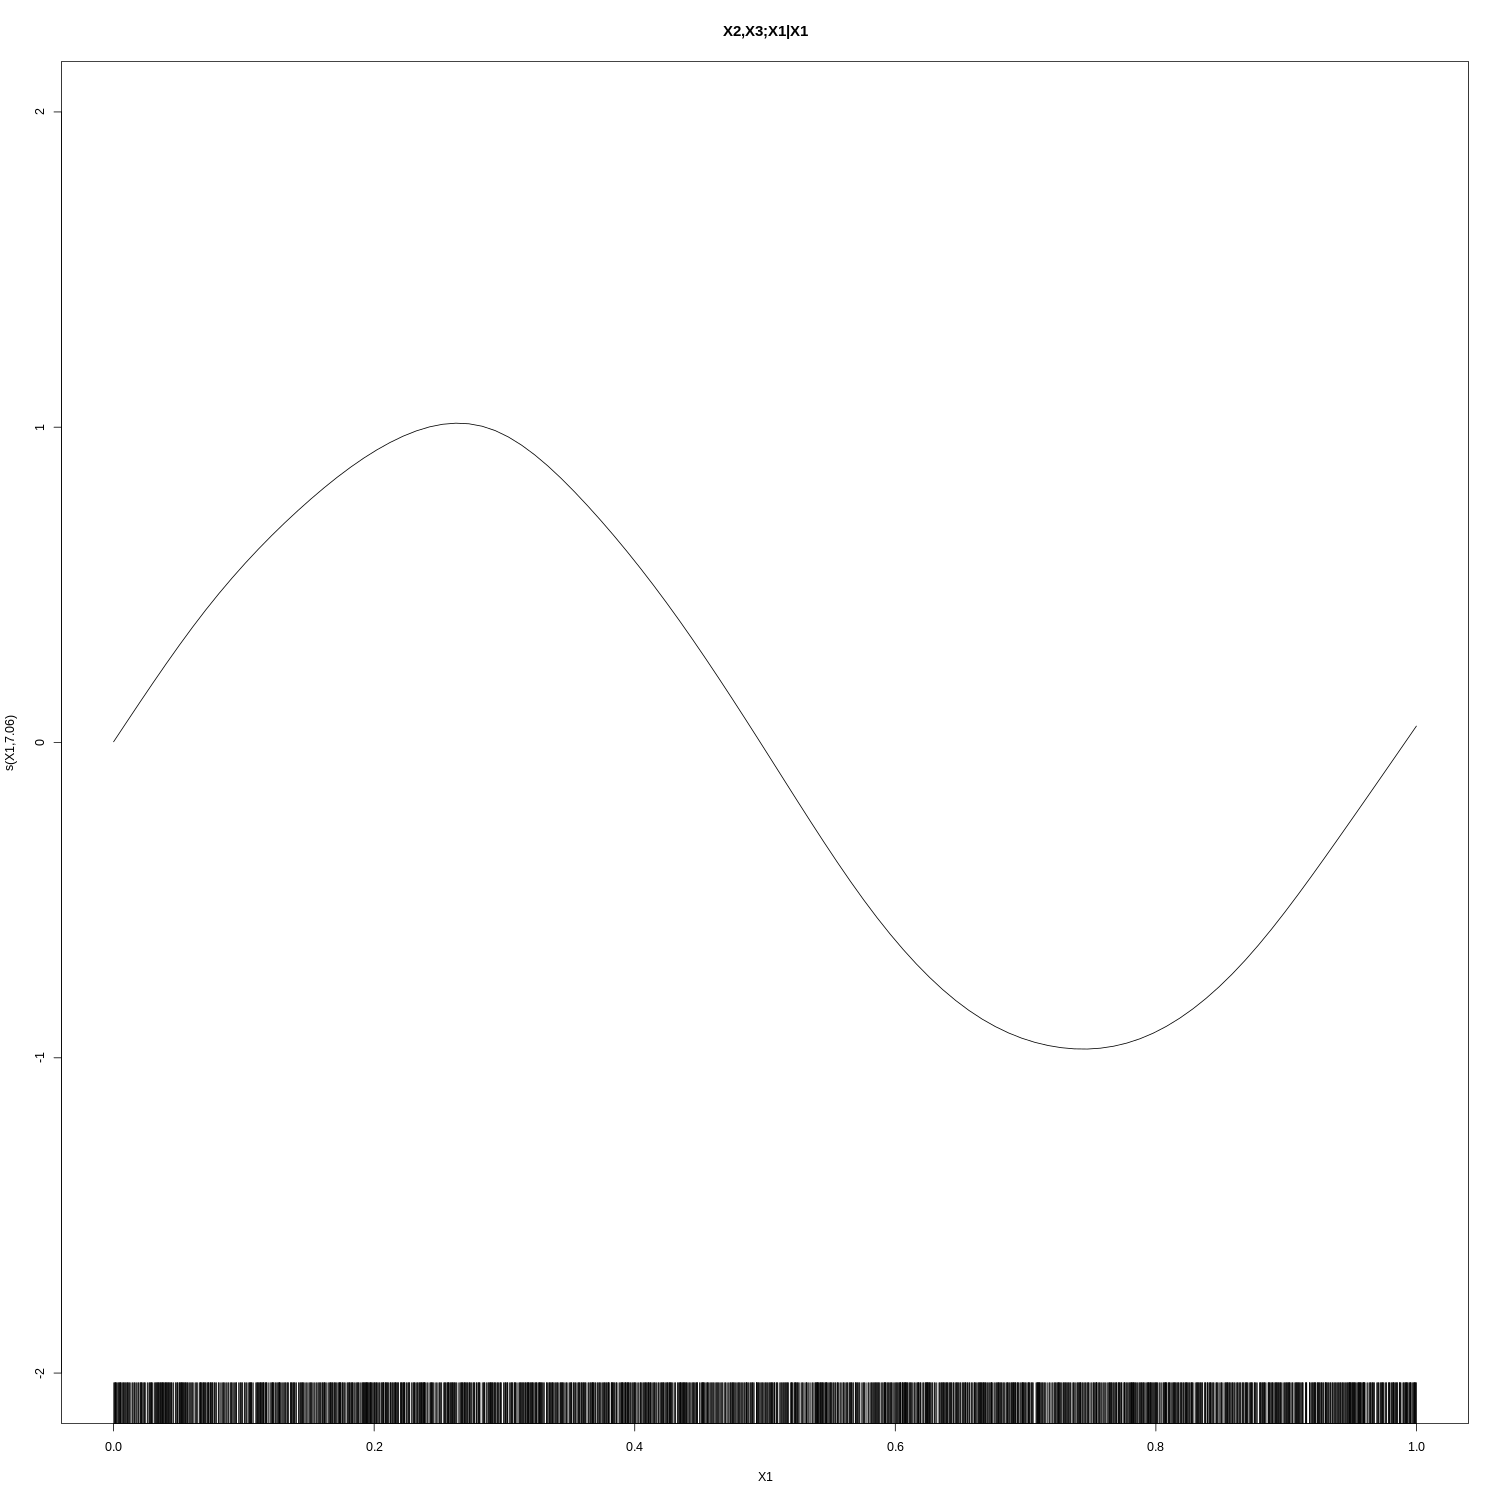

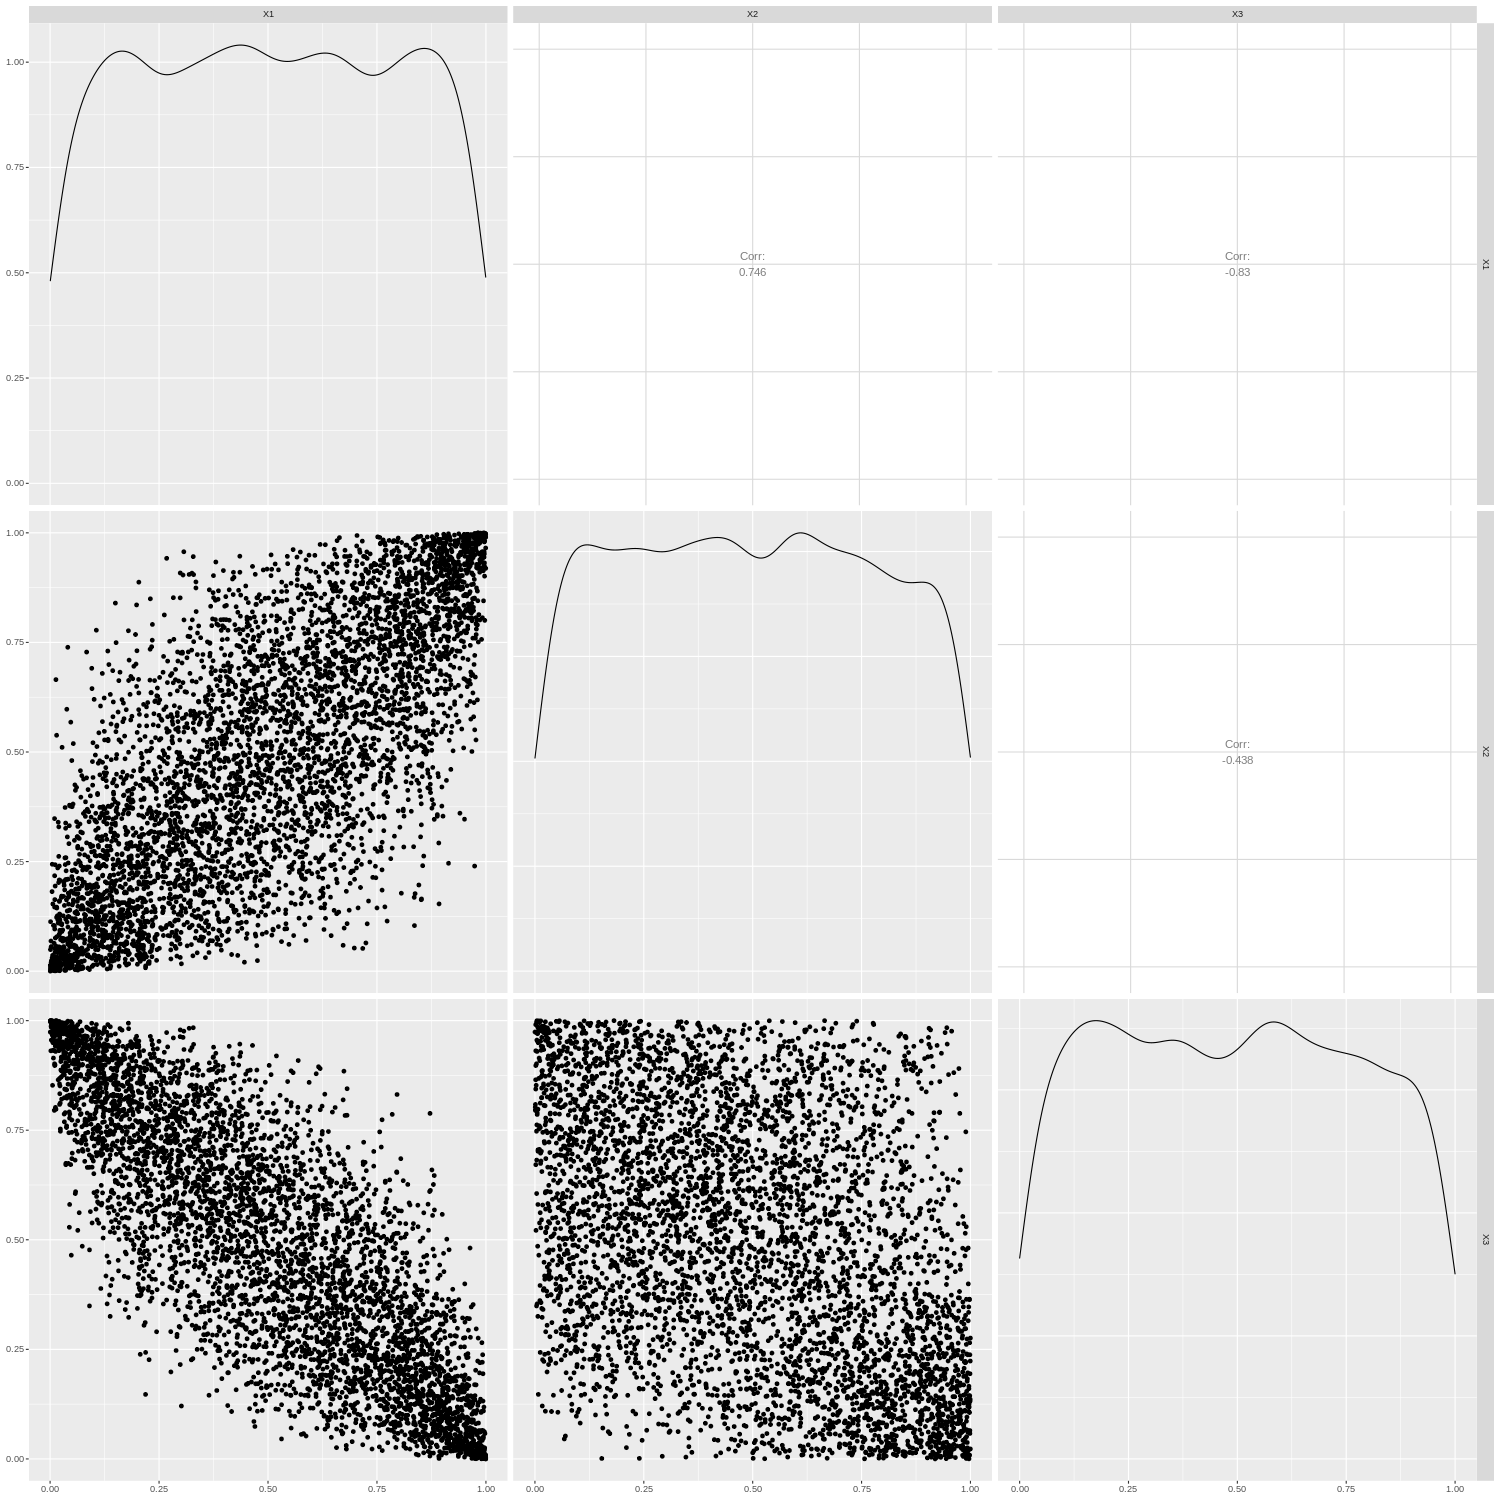

In [26]:
plot(fit1, ylim = c(-2, 2))
fit.data <- gamVineSimulate(5000,fit1)
ggpairs(data.frame(fit.data))

Notes regarding this phenomenon: It seems like even though sometimes the fit of the generalized additive model is off, the overall (pairs) plot still corresponds to what you would expect from the data, i.e. it looks the same as simulating directly from the original gamVine. This makes sense, since we are maximizing (penalized) likelihood and NOT maximizing the fit of gam to the true function (the true function is not known to the algorithm!)